

### Install the below if not installed

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
#initialize the accelerator
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
#connect to wandb
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "movie-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from google.colab import drive
drive.mount('/content/drive')

from datasets import load_dataset

train_dataset = load_dataset('json', data_files='drive/MyDrive/training.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='drive/MyDrive/validation.jsonl', split='train')

Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
train_dataset[0]

{'rating': 'Good',
 'movie1': 'Mighty Aphrodite (1995)',
 'movie2': 'Aliens (1986)',
 'movie3': 'Braveheart (1995)',
 'movie4': 'Star Trek: The Wrath of Khan (1982)',
 'movie5': 'This Is Spinal Tap (1984)',
 'movie6': 'Blade Runner (1982)',
 'genre1': 'comedy',
 'genre2': 'war',
 'genre3': 'war',
 'genre4': 'sci-fi',
 'genre5': 'musical',
 'genre6': 'sci-fi'}




### Formatting prompts
create a `formatting_func` to structure training examples as prompts.

In [6]:
def formatting_func(example):
    prompt = f"A user has rated the movies "
    for i in range(1, 5):
        movie_key = f"movie{i}"
        prompt += f"{example[movie_key]}, "
    movie_key = f"movie{5}"
    prompt += f"{example[movie_key]}"
    movie_key = f"movie{6}"
    prompt += f" as {example['rating']}. Would the user rate {example[movie_key]} as Good or Bad? Output only one of Good or Bad."
    response = f"{example['rating']}"
    return prompt, response

In [7]:
formatting_func(train_dataset[0])

('A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.',
 'Good')

In [8]:
def formatting_func_with_genre(example):
    prompt = f"A user has rated the movies "
    for i in range(1, 5):
        movie_key = f"movie{i}"
        prompt += f"{example[movie_key]}"
        genre_key = f"genre{i}"
        prompt += f" of the genre {example[genre_key]}, "
    movie_key = f"movie{5}"
    prompt += f"{example[movie_key]}"
    genre_key = f"genre{5}"
    prompt += f" of the genre {example[genre_key]},"
    movie_key = f"movie{6}"
    genre_key = f"genre{6}"
    prompt += f" as {example['rating']}. Would the user rate {example[movie_key]} of the genre {example[genre_key]} as Good or Bad? Output only one of Good or Bad."
    response = f"{example['rating']}"
    return prompt, response

In [9]:
formatting_func_with_genre(train_dataset[0])

('A user has rated the movies Mighty Aphrodite (1995) of the genre comedy, Aliens (1986) of the genre war, Braveheart (1995) of the genre war, Star Trek: The Wrath of Khan (1982) of the genre sci-fi, This Is Spinal Tap (1984) of the genre musical, as Good. Would the user rate Blade Runner (1982) of the genre sci-fi as Good or Bad? Output only one of Good or Bad.',
 'Good')

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 3. Tokenization with movies

Set up the tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt)[0], formatting_func(prompt)[1])

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Reformat the prompt and tokenize each sample:

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/2054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

156


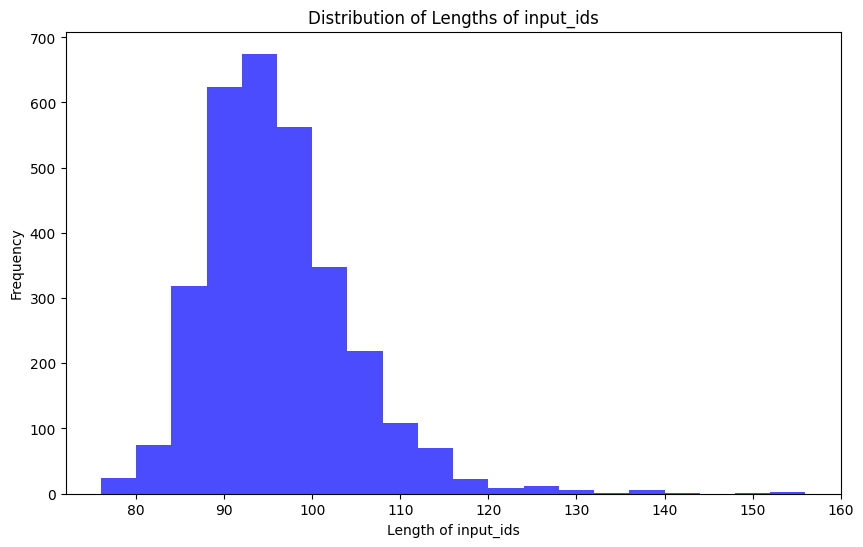

In [13]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(max(lengths))
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
max_length = 148 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt)[0],
        formatting_func(prompt)[1],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    return result

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/2054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [16]:
print(tokenized_train_dataset[0])

{'rating': 'Good', 'movie1': 'Mighty Aphrodite (1995)', 'movie2': 'Aliens (1986)', 'movie3': 'Braveheart (1995)', 'movie4': 'Star Trek: The Wrath of Khan (1982)', 'movie5': 'This Is Spinal Tap (1984)', 'movie6': 'Blade Runner (1982)', 'genre1': 'comedy', 'genre2': 'war', 'genre3': 'war', 'genre4': 'sci-fi', 'genre5': 'musical', 'genre6': 'sci-fi', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 330, 2188, 659, 25101, 272, 10615, 28439, 28724, 330, 721, 9413, 570, 325, 28740, 28774, 28774, 28782, 557, 976, 12306, 325, 28740, 28774, 28783, 28784, 557, 1896, 458, 14754, 325, 28740, 28774, 28774, 28782, 557, 7383, 9485, 28729, 28747, 415, 16258, 498, 302, 18595, 325, 28740, 28774, 28783, 28750, 557, 851, 1691, 1670, 1475, 320, 377, 325, 28740, 28774, 28783, 28781, 28731, 390, 5801, 28723, 11312, 272, 2188, 4338, 2025, 770, 6320, 1079, 325, 28740, 28774, 28783, 28750, 28

Now all the samples should be the same length, `max_length`.

148


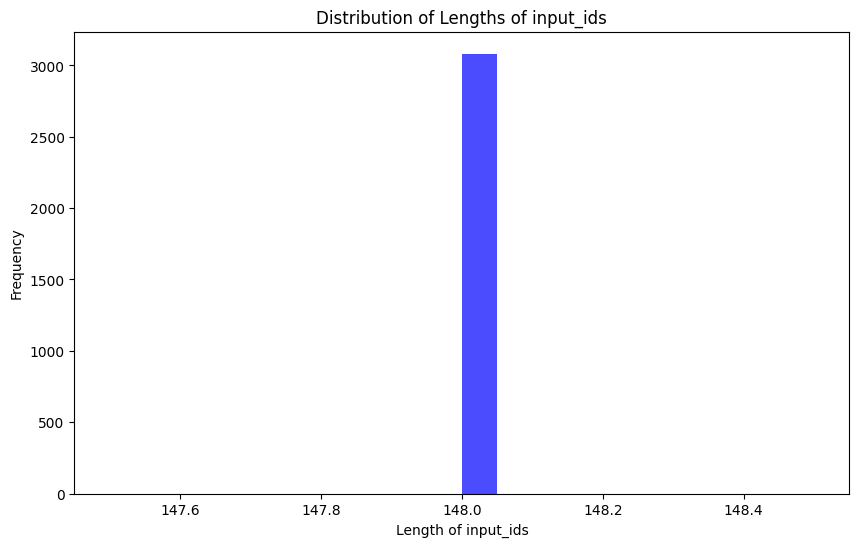

In [17]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [18]:
eval_prompt = "A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad."

In [19]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.

```
Good
```

A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.


In [20]:
model_input

{'input_ids': tensor([[    1,   330,  2188,   659, 25101,   272, 10615, 28439, 28724,   330,
           721,  9413,   570,   325, 28740, 28774, 28774, 28782,   557,   976,
         12306,   325, 28740, 28774, 28783, 28784,   557,  1896,   458, 14754,
           325, 28740, 28774, 28774, 28782,   557,  7383,  9485, 28729, 28747,
           415, 16258,   498,   302, 18595,   325, 28740, 28774, 28783, 28750,
           557,   851,  1691,  1670,  1475,   320,   377,   325, 28740, 28774,
         28783, 28781, 28731,   390,  5801, 28723, 11312,   272,  2188,  4338,
          2025,   770,  6320,  1079,   325, 28740, 28774, 28783, 28750, 28731,
           390,  5801,   442,  9734, 28804, 15985,   865,   624,   302,  5801,
           442,  9734, 28723]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
import pandas as pd
ratings_data = pd.read_csv("drive/MyDrive/movie_ratings.csv")
ratings_data

,movieid,movietitle,rating
0,1,Toy Story (1995),3
1,2,GoldenEye (1995),3
2,3,Four Rooms (1995),3
3,4,Get Shorty (1995),3
4,5,Copycat (1995),3
...,...,...,...
1677,1678,Mat' i syn (1997),1
1678,1679,B. Monkey (1998),3
1679,1680,Sliding Doors (1998),2
1680,1681,You So Crazy (1994),3


In [23]:
from tqdm import tqdm
import re
prompts = [
    f'Rate the movie {x} on a scale of 1 to 5. Return only an integer from 1 to 5' for x in ratings_data['movietitle']
]

# Generating ratings for each movie
predicted_ratings = []
for prompt in tqdm(prompts):
    model_input = eval_tokenizer(prompt, return_tensors="pt").to("cuda")
    result = eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)
    try:
        marker = "```"
        marker_index = result.find(marker)
        if marker_index != -1:
            text_after_marker = result[marker_index + len(marker):]

        m = re.search(r'\b\d\b', text_after_marker)
        predicted_ratings.append(int(m.group()) if m else None)
    except:
        predicted_ratings.append(None)

  0%|          | 2/1682 [00:00<02:52,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 4/1682 [00:00<02:53,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 6/1682 [00:00<02:53,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 8/1682 [00:00<02:54,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 10/1682 [00:01<02:53,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 12/1682 [00:01<02:53,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 14/1682 [00:01<02:53,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 16/1682 [00:01<02:52,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 18/1682 [00:01<02:53,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 20/1682 [00:02<02:52,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 22/1682 [00:02<02:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 24/1682 [00:02<02:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 26/1682 [00:02<02:52,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 28/1682 [00:02<02:49,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 30/1682 [00:03<02:50,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 32/1682 [00:03<02:51,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 34/1682 [00:03<02:51,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 36/1682 [00:03<02:52,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 38/1682 [00:03<02:53,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 40/1682 [00:04<02:53,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 42/1682 [00:04<02:53,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 44/1682 [00:04<02:51,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 46/1682 [00:04<02:50,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 48/1682 [00:04<02:49,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 50/1682 [00:05<02:49,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 52/1682 [00:05<02:48,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 54/1682 [00:05<02:47,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 56/1682 [00:05<02:47,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 58/1682 [00:06<02:47,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 60/1682 [00:06<02:45,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 62/1682 [00:06<02:44,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 64/1682 [00:06<02:44,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 66/1682 [00:06<02:44,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 68/1682 [00:07<02:43,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 70/1682 [00:07<02:43,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 72/1682 [00:07<02:42,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 74/1682 [00:07<02:42,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 76/1682 [00:07<02:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 78/1682 [00:08<02:42,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 80/1682 [00:08<02:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 82/1682 [00:08<02:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 84/1682 [00:08<02:42,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 86/1682 [00:08<02:41,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 88/1682 [00:09<02:41,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 90/1682 [00:09<02:41,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 92/1682 [00:09<02:41,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 94/1682 [00:09<02:40,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 96/1682 [00:09<02:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 98/1682 [00:10<02:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 100/1682 [00:10<02:40,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 102/1682 [00:10<02:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 104/1682 [00:10<02:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 106/1682 [00:10<02:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 108/1682 [00:11<02:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 110/1682 [00:11<02:39,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 112/1682 [00:11<02:39,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 114/1682 [00:11<02:38,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 116/1682 [00:11<02:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 118/1682 [00:12<02:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 120/1682 [00:12<02:38,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 122/1682 [00:12<02:38,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 124/1682 [00:12<02:37,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 126/1682 [00:12<02:37,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 128/1682 [00:13<02:37,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 130/1682 [00:13<02:37,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 132/1682 [00:13<02:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 134/1682 [00:13<02:36,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 136/1682 [00:13<02:36,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 138/1682 [00:14<02:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 140/1682 [00:14<02:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 142/1682 [00:14<02:35,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 144/1682 [00:14<02:35,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 146/1682 [00:14<02:35,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 148/1682 [00:15<02:35,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 150/1682 [00:15<02:35,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 152/1682 [00:15<02:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 154/1682 [00:15<02:35,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 156/1682 [00:15<02:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 158/1682 [00:16<02:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 160/1682 [00:16<02:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 162/1682 [00:16<02:34,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 164/1682 [00:16<02:33,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 166/1682 [00:16<02:33,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 168/1682 [00:17<02:33,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 170/1682 [00:17<02:33,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 172/1682 [00:17<02:32,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 174/1682 [00:17<02:32,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 176/1682 [00:17<02:32,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 178/1682 [00:18<02:32,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 180/1682 [00:18<02:32,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 182/1682 [00:18<02:32,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 184/1682 [00:18<02:31,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 186/1682 [00:18<02:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 188/1682 [00:19<02:31,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 190/1682 [00:19<02:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 192/1682 [00:19<02:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 194/1682 [00:19<02:30,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 196/1682 [00:20<02:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 198/1682 [00:20<02:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 200/1682 [00:20<02:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 202/1682 [00:20<02:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 204/1682 [00:20<02:29,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 206/1682 [00:21<02:29,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 208/1682 [00:21<02:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 210/1682 [00:21<02:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 212/1682 [00:21<02:28,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 214/1682 [00:21<02:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 216/1682 [00:22<02:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 218/1682 [00:22<02:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 220/1682 [00:22<02:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 222/1682 [00:22<02:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 224/1682 [00:22<02:27,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 226/1682 [00:23<02:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 228/1682 [00:23<02:27,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 230/1682 [00:23<02:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 232/1682 [00:23<02:27,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 234/1682 [00:23<02:26,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 236/1682 [00:24<02:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 238/1682 [00:24<02:26,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 240/1682 [00:24<02:26,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 242/1682 [00:24<02:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 244/1682 [00:24<02:25,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 246/1682 [00:25<02:25,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 248/1682 [00:25<02:25,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 250/1682 [00:25<02:25,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 252/1682 [00:25<02:24,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 254/1682 [00:25<02:24,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 256/1682 [00:26<02:24,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 258/1682 [00:26<02:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 260/1682 [00:26<02:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 262/1682 [00:26<02:23,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 264/1682 [00:26<02:23,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 266/1682 [00:27<02:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 268/1682 [00:27<02:23,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 270/1682 [00:27<02:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 272/1682 [00:27<02:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 274/1682 [00:27<02:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 276/1682 [00:28<02:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 278/1682 [00:28<02:22,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 280/1682 [00:28<02:22,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 282/1682 [00:28<02:21,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 284/1682 [00:28<02:21,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 286/1682 [00:29<02:21,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 288/1682 [00:29<02:21,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 290/1682 [00:29<02:20,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 292/1682 [00:29<02:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 294/1682 [00:29<02:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 296/1682 [00:30<02:20,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 298/1682 [00:30<02:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 300/1682 [00:30<02:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 302/1682 [00:30<02:20,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 304/1682 [00:30<02:19,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 306/1682 [00:31<02:19,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 308/1682 [00:31<02:19,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 310/1682 [00:31<02:19,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 312/1682 [00:31<02:19,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 314/1682 [00:31<02:18,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 316/1682 [00:32<02:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 318/1682 [00:32<02:18,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 320/1682 [00:32<02:18,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 322/1682 [00:32<02:17,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 324/1682 [00:32<02:17,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 326/1682 [00:33<02:17,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 328/1682 [00:33<02:17,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 330/1682 [00:33<02:17,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 332/1682 [00:33<02:16,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 334/1682 [00:33<02:16,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 336/1682 [00:34<02:16,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 338/1682 [00:34<02:16,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 340/1682 [00:34<02:16,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 342/1682 [00:34<02:15,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 344/1682 [00:35<02:15,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 346/1682 [00:35<02:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 348/1682 [00:35<02:15,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 350/1682 [00:35<02:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 352/1682 [00:35<02:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 354/1682 [00:36<02:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 356/1682 [00:36<02:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 358/1682 [00:36<02:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 360/1682 [00:36<02:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 362/1682 [00:36<02:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 364/1682 [00:37<02:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 366/1682 [00:37<02:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 368/1682 [00:37<02:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 370/1682 [00:37<02:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 372/1682 [00:37<02:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 374/1682 [00:38<02:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 376/1682 [00:38<02:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 378/1682 [00:38<02:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 380/1682 [00:38<02:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 382/1682 [00:38<02:11,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 384/1682 [00:39<02:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 386/1682 [00:39<02:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 388/1682 [00:39<02:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 390/1682 [00:39<02:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 392/1682 [00:39<02:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 394/1682 [00:40<02:10,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 396/1682 [00:40<02:10,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 398/1682 [00:40<02:10,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 400/1682 [00:40<02:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 402/1682 [00:40<02:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 404/1682 [00:41<02:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 406/1682 [00:41<02:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 408/1682 [00:41<02:09,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 410/1682 [00:41<02:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 412/1682 [00:41<02:08,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 414/1682 [00:42<02:08,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 416/1682 [00:42<02:08,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 418/1682 [00:42<02:08,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 420/1682 [00:42<02:07,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 422/1682 [00:42<02:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 424/1682 [00:43<02:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 426/1682 [00:43<02:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 428/1682 [00:43<02:07,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 430/1682 [00:43<02:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 432/1682 [00:43<02:06,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 434/1682 [00:44<02:06,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 436/1682 [00:44<02:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 438/1682 [00:44<02:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 440/1682 [00:44<02:06,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 442/1682 [00:44<02:05,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 444/1682 [00:45<02:05,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 446/1682 [00:45<02:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 448/1682 [00:45<02:05,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 450/1682 [00:45<02:04,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 452/1682 [00:45<02:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 454/1682 [00:46<02:04,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 456/1682 [00:46<02:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 458/1682 [00:46<02:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 460/1682 [00:46<02:04,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 462/1682 [00:46<02:04,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 464/1682 [00:47<02:03,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 466/1682 [00:47<02:03,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 468/1682 [00:47<02:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 470/1682 [00:47<02:02,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 472/1682 [00:47<02:02,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 474/1682 [00:48<02:02,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 476/1682 [00:48<02:02,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 478/1682 [00:48<02:01,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 480/1682 [00:48<02:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 482/1682 [00:48<02:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 484/1682 [00:49<02:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 486/1682 [00:49<02:01,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 488/1682 [00:49<02:00,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 490/1682 [00:49<02:00,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 492/1682 [00:49<02:00,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 494/1682 [00:50<02:00,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 496/1682 [00:50<02:00,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 498/1682 [00:50<01:59,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 500/1682 [00:50<02:00,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 502/1682 [00:51<01:59,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 504/1682 [00:51<01:59,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 506/1682 [00:51<01:59,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 508/1682 [00:51<01:58,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 510/1682 [00:51<01:58,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 512/1682 [00:52<01:58,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 514/1682 [00:52<01:58,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 516/1682 [00:52<01:58,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 518/1682 [00:52<01:57,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 520/1682 [00:52<01:57,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 522/1682 [00:53<01:57,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 524/1682 [00:53<01:57,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 526/1682 [00:53<01:57,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 528/1682 [00:53<01:57,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 530/1682 [00:53<01:56,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 532/1682 [00:54<01:56,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 534/1682 [00:54<01:56,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 536/1682 [00:54<01:56,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 538/1682 [00:54<01:56,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 540/1682 [00:54<01:55,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 542/1682 [00:55<01:55,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 544/1682 [00:55<01:55,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 546/1682 [00:55<01:55,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 548/1682 [00:55<01:54,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 550/1682 [00:55<01:54,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 552/1682 [00:56<01:54,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 554/1682 [00:56<01:54,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 556/1682 [00:56<01:54,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 558/1682 [00:56<01:53,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 560/1682 [00:56<01:53,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 562/1682 [00:57<01:53,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 564/1682 [00:57<01:53,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 566/1682 [00:57<01:53,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 568/1682 [00:57<01:52,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 570/1682 [00:57<01:52,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 572/1682 [00:58<01:52,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 574/1682 [00:58<01:52,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 576/1682 [00:58<01:52,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 578/1682 [00:58<01:52,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 580/1682 [00:58<01:51,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 582/1682 [00:59<01:51,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 584/1682 [00:59<01:51,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 586/1682 [00:59<01:50,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 588/1682 [00:59<01:50,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 590/1682 [00:59<01:50,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 592/1682 [01:00<01:50,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 594/1682 [01:00<01:50,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 596/1682 [01:00<01:50,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 598/1682 [01:00<01:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 600/1682 [01:00<01:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 602/1682 [01:01<01:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 604/1682 [01:01<01:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 606/1682 [01:01<01:49,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 608/1682 [01:01<01:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 610/1682 [01:01<01:48,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 612/1682 [01:02<01:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 614/1682 [01:02<01:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 616/1682 [01:02<01:47,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 618/1682 [01:02<01:47,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 620/1682 [01:02<01:47,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 622/1682 [01:03<01:47,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 624/1682 [01:03<01:47,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 626/1682 [01:03<01:47,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 628/1682 [01:03<01:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 630/1682 [01:03<01:46,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 632/1682 [01:04<01:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 634/1682 [01:04<01:46,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 636/1682 [01:04<01:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 638/1682 [01:04<01:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 640/1682 [01:05<01:45,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 642/1682 [01:05<01:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 644/1682 [01:05<01:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 646/1682 [01:05<01:44,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 648/1682 [01:05<01:44,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 650/1682 [01:06<01:44,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 652/1682 [01:06<01:44,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 654/1682 [01:06<01:44,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 656/1682 [01:06<01:44,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 658/1682 [01:06<01:43,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 660/1682 [01:07<01:43,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 662/1682 [01:07<01:43,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 664/1682 [01:07<01:43,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 666/1682 [01:07<01:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 668/1682 [01:07<01:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 670/1682 [01:08<01:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 672/1682 [01:08<01:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 674/1682 [01:08<01:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 676/1682 [01:08<01:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 678/1682 [01:08<01:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 680/1682 [01:09<01:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 682/1682 [01:09<01:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 684/1682 [01:09<01:41,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 686/1682 [01:09<01:40,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 688/1682 [01:09<01:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 690/1682 [01:10<01:40,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 692/1682 [01:10<01:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 694/1682 [01:10<01:40,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 696/1682 [01:10<01:40,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 698/1682 [01:10<01:39,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 700/1682 [01:11<01:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 702/1682 [01:11<01:39,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 704/1682 [01:11<01:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 706/1682 [01:11<01:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 708/1682 [01:11<01:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 710/1682 [01:12<01:38,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 712/1682 [01:12<01:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 714/1682 [01:12<01:37,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 716/1682 [01:12<01:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 718/1682 [01:12<01:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 720/1682 [01:13<01:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 722/1682 [01:13<01:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 724/1682 [01:13<01:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 726/1682 [01:13<01:36,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 728/1682 [01:13<01:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 730/1682 [01:14<01:36,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 732/1682 [01:14<01:36,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 734/1682 [01:14<01:36,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 736/1682 [01:14<01:36,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 738/1682 [01:14<01:35,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 740/1682 [01:15<01:35,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 742/1682 [01:15<01:35,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 744/1682 [01:15<01:34,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 746/1682 [01:15<01:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 748/1682 [01:15<01:34,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 750/1682 [01:16<01:34,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 752/1682 [01:16<01:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 754/1682 [01:16<01:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 756/1682 [01:16<01:33,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 758/1682 [01:16<01:33,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 760/1682 [01:17<01:33,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 762/1682 [01:17<01:33,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 764/1682 [01:17<01:33,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 766/1682 [01:17<01:32,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 768/1682 [01:17<01:32,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 770/1682 [01:18<01:32,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 772/1682 [01:18<01:32,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 774/1682 [01:18<01:31,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 776/1682 [01:18<01:31,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 778/1682 [01:18<01:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 780/1682 [01:19<01:31,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 782/1682 [01:19<01:31,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 784/1682 [01:19<01:31,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 786/1682 [01:19<01:30,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 788/1682 [01:20<01:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 790/1682 [01:20<01:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 792/1682 [01:20<01:30,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 794/1682 [01:20<01:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 796/1682 [01:20<01:29,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 798/1682 [01:21<01:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 800/1682 [01:21<01:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 802/1682 [01:21<01:29,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 804/1682 [01:21<01:29,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 806/1682 [01:21<01:28,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 808/1682 [01:22<01:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 810/1682 [01:22<01:28,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 812/1682 [01:22<01:27,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 814/1682 [01:22<01:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 816/1682 [01:22<01:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 818/1682 [01:23<01:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 820/1682 [01:23<01:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 822/1682 [01:23<01:27,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 824/1682 [01:23<01:26,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 826/1682 [01:23<01:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 828/1682 [01:24<01:26,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 830/1682 [01:24<01:26,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 832/1682 [01:24<01:26,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 834/1682 [01:24<01:25,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 836/1682 [01:24<01:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 838/1682 [01:25<01:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 840/1682 [01:25<01:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 842/1682 [01:25<01:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 844/1682 [01:25<01:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 846/1682 [01:25<01:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 848/1682 [01:26<01:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 850/1682 [01:26<01:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 852/1682 [01:26<01:24,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 854/1682 [01:26<01:23,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 856/1682 [01:26<01:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 858/1682 [01:27<01:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 860/1682 [01:27<01:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 862/1682 [01:27<01:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 864/1682 [01:27<01:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 866/1682 [01:27<01:22,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 868/1682 [01:28<01:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 870/1682 [01:28<01:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 872/1682 [01:28<01:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 874/1682 [01:28<01:21,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 876/1682 [01:28<01:21,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 878/1682 [01:29<01:21,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 880/1682 [01:29<01:21,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 882/1682 [01:29<01:21,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 884/1682 [01:29<01:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 886/1682 [01:29<01:20,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 888/1682 [01:30<01:20,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 890/1682 [01:30<01:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 892/1682 [01:30<01:20,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 894/1682 [01:30<01:19,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 896/1682 [01:30<01:19,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 898/1682 [01:31<01:19,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 900/1682 [01:31<01:19,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 902/1682 [01:31<01:19,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 904/1682 [01:31<01:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 906/1682 [01:31<01:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 908/1682 [01:32<01:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 910/1682 [01:32<01:18,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 912/1682 [01:32<01:18,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 914/1682 [01:32<01:17,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 916/1682 [01:32<01:17,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 918/1682 [01:33<01:17,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 920/1682 [01:33<01:17,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 922/1682 [01:33<01:17,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 924/1682 [01:33<01:17,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 926/1682 [01:33<01:16,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 928/1682 [01:34<01:16,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 930/1682 [01:34<01:16,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 932/1682 [01:34<01:15,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 934/1682 [01:34<01:15,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 936/1682 [01:34<01:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 938/1682 [01:35<01:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 940/1682 [01:35<01:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 942/1682 [01:35<01:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 944/1682 [01:35<01:14,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 946/1682 [01:36<01:14,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 948/1682 [01:36<01:14,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 950/1682 [01:36<01:14,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 952/1682 [01:36<01:14,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 954/1682 [01:36<01:13,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 956/1682 [01:37<01:13,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 958/1682 [01:37<01:13,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 960/1682 [01:37<01:13,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 962/1682 [01:37<01:12,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 964/1682 [01:37<01:12,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 966/1682 [01:38<01:12,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 968/1682 [01:38<01:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 970/1682 [01:38<01:12,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 972/1682 [01:38<01:12,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 974/1682 [01:38<01:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 976/1682 [01:39<01:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 978/1682 [01:39<01:11,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 980/1682 [01:39<01:11,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 982/1682 [01:39<01:10,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 984/1682 [01:39<01:10,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 986/1682 [01:40<01:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 988/1682 [01:40<01:10,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 990/1682 [01:40<01:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 992/1682 [01:40<01:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 994/1682 [01:40<01:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 996/1682 [01:41<01:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 998/1682 [01:41<01:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 1000/1682 [01:41<01:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1002/1682 [01:41<01:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1004/1682 [01:41<01:08,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1006/1682 [01:42<01:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1008/1682 [01:42<01:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1010/1682 [01:42<01:08,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1012/1682 [01:42<01:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1014/1682 [01:42<01:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1016/1682 [01:43<01:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1018/1682 [01:43<01:07,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1020/1682 [01:43<01:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1022/1682 [01:43<01:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1024/1682 [01:43<01:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1026/1682 [01:44<01:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1028/1682 [01:44<01:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1030/1682 [01:44<01:06,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1032/1682 [01:44<01:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1034/1682 [01:44<01:05,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1036/1682 [01:45<01:05,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1038/1682 [01:45<01:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1040/1682 [01:45<01:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1042/1682 [01:45<01:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1044/1682 [01:45<01:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1046/1682 [01:46<01:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1048/1682 [01:46<01:04,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1050/1682 [01:46<01:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1052/1682 [01:46<01:03,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1054/1682 [01:46<01:03,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1056/1682 [01:47<01:03,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1058/1682 [01:47<01:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1060/1682 [01:47<01:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1062/1682 [01:47<01:02,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1064/1682 [01:47<01:02,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1066/1682 [01:48<01:02,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1068/1682 [01:48<01:02,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1070/1682 [01:48<01:02,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1072/1682 [01:48<01:02,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1074/1682 [01:48<01:01,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1076/1682 [01:49<01:01,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1078/1682 [01:49<01:01,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1080/1682 [01:49<01:01,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1082/1682 [01:49<01:00,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1084/1682 [01:49<01:00,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1086/1682 [01:50<01:00,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1088/1682 [01:50<01:00,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1090/1682 [01:50<00:59,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1092/1682 [01:50<00:59,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1094/1682 [01:51<00:59,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1096/1682 [01:51<00:59,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1098/1682 [01:51<00:59,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1100/1682 [01:51<00:59,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1102/1682 [01:51<01:00,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1104/1682 [01:52<01:00,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1106/1682 [01:52<01:00,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1108/1682 [01:52<00:59,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1110/1682 [01:52<00:58,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1112/1682 [01:52<00:57,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1114/1682 [01:53<00:57,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1116/1682 [01:53<00:57,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1118/1682 [01:53<00:57,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1120/1682 [01:53<00:56,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1122/1682 [01:53<00:56,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1124/1682 [01:54<00:56,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1126/1682 [01:54<00:56,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1128/1682 [01:54<00:56,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1130/1682 [01:54<00:55,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1132/1682 [01:54<00:55,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1134/1682 [01:55<00:55,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1136/1682 [01:55<00:55,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1138/1682 [01:55<00:55,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1140/1682 [01:55<00:54,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1142/1682 [01:55<00:54,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1144/1682 [01:56<00:54,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1146/1682 [01:56<00:54,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1148/1682 [01:56<00:54,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1150/1682 [01:56<00:53,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1152/1682 [01:56<00:53,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1154/1682 [01:57<00:53,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1156/1682 [01:57<00:53,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1158/1682 [01:57<00:53,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1160/1682 [01:57<00:52,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1162/1682 [01:57<00:52,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1164/1682 [01:58<00:52,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1166/1682 [01:58<00:52,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1168/1682 [01:58<00:52,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1170/1682 [01:58<00:51,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1172/1682 [01:58<00:51,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1174/1682 [01:59<00:51,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1176/1682 [01:59<00:51,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1178/1682 [01:59<00:51,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1180/1682 [01:59<00:50,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1182/1682 [01:59<00:50,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1184/1682 [02:00<00:50,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1186/1682 [02:00<00:50,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1188/1682 [02:00<00:49,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1190/1682 [02:00<00:49,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1192/1682 [02:00<00:49,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1194/1682 [02:01<00:49,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1196/1682 [02:01<00:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1198/1682 [02:01<00:49,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1200/1682 [02:01<00:48,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1202/1682 [02:01<00:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1204/1682 [02:02<00:48,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1206/1682 [02:02<00:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1208/1682 [02:02<00:48,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1210/1682 [02:02<00:47,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1212/1682 [02:03<00:47,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1214/1682 [02:03<00:47,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1216/1682 [02:03<00:47,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1218/1682 [02:03<00:47,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1220/1682 [02:03<00:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1222/1682 [02:04<00:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1224/1682 [02:04<00:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1226/1682 [02:04<00:46,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1228/1682 [02:04<00:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1230/1682 [02:04<00:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1232/1682 [02:05<00:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1234/1682 [02:05<00:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1236/1682 [02:05<00:45,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1238/1682 [02:05<00:44,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1240/1682 [02:05<00:44,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1242/1682 [02:06<00:44,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1244/1682 [02:06<00:44,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1246/1682 [02:06<00:44,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1248/1682 [02:06<00:43,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1250/1682 [02:06<00:43,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1252/1682 [02:07<00:43,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1254/1682 [02:07<00:43,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1256/1682 [02:07<00:43,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1258/1682 [02:07<00:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1260/1682 [02:07<00:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1262/1682 [02:08<00:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1264/1682 [02:08<00:42,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1266/1682 [02:08<00:42,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1268/1682 [02:08<00:41,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1270/1682 [02:08<00:41,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1272/1682 [02:09<00:44,  9.24it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1274/1682 [02:09<00:43,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1276/1682 [02:09<00:42,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1278/1682 [02:09<00:42,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1280/1682 [02:09<00:41,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1282/1682 [02:10<00:40,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1284/1682 [02:10<00:40,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1286/1682 [02:10<00:40,  9.83it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1288/1682 [02:10<00:39,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1290/1682 [02:10<00:39,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1292/1682 [02:11<00:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1294/1682 [02:11<00:39,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1296/1682 [02:11<00:39,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1298/1682 [02:11<00:38,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1300/1682 [02:11<00:38,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1302/1682 [02:12<00:38,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1304/1682 [02:12<00:38,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1306/1682 [02:12<00:38,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1308/1682 [02:12<00:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1310/1682 [02:12<00:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1312/1682 [02:13<00:37,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1314/1682 [02:13<00:37,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1316/1682 [02:13<00:37,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1318/1682 [02:13<00:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1320/1682 [02:13<00:36,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1322/1682 [02:14<00:36,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1324/1682 [02:14<00:36,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1326/1682 [02:14<00:36,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1328/1682 [02:14<00:35,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1330/1682 [02:14<00:35,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1332/1682 [02:15<00:35,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1334/1682 [02:15<00:35,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1336/1682 [02:15<00:35,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1338/1682 [02:15<00:34,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1340/1682 [02:16<00:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1342/1682 [02:16<00:34,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1344/1682 [02:16<00:34,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1346/1682 [02:16<00:34,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1348/1682 [02:16<00:33,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1350/1682 [02:17<00:33,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1352/1682 [02:17<00:33,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1354/1682 [02:17<00:33,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1356/1682 [02:17<00:33,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1358/1682 [02:17<00:32,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1360/1682 [02:18<00:32,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1362/1682 [02:18<00:32,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1364/1682 [02:18<00:32,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1366/1682 [02:18<00:32,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1368/1682 [02:18<00:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1370/1682 [02:19<00:31,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1372/1682 [02:19<00:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1374/1682 [02:19<00:31,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1376/1682 [02:19<00:30,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1378/1682 [02:19<00:30,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1380/1682 [02:20<00:30,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1382/1682 [02:20<00:30,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1384/1682 [02:20<00:30,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1386/1682 [02:20<00:29,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1388/1682 [02:20<00:29,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1390/1682 [02:21<00:29,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1392/1682 [02:21<00:29,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1394/1682 [02:21<00:29,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1396/1682 [02:21<00:29,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1398/1682 [02:21<00:28,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1400/1682 [02:22<00:28,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1402/1682 [02:22<00:28,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1404/1682 [02:22<00:28,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1406/1682 [02:22<00:28,  9.82it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1408/1682 [02:22<00:27,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1410/1682 [02:23<00:27,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1412/1682 [02:23<00:27,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1414/1682 [02:23<00:27,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1416/1682 [02:23<00:26,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1418/1682 [02:23<00:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1420/1682 [02:24<00:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1422/1682 [02:24<00:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1424/1682 [02:24<00:26,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1426/1682 [02:24<00:25,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1428/1682 [02:24<00:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1430/1682 [02:25<00:25,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1432/1682 [02:25<00:25,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1434/1682 [02:25<00:25,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1436/1682 [02:25<00:24,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1438/1682 [02:25<00:24,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1440/1682 [02:26<00:24,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1442/1682 [02:26<00:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1444/1682 [02:26<00:24,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1446/1682 [02:26<00:23,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1448/1682 [02:26<00:23,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1450/1682 [02:27<00:23,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1452/1682 [02:27<00:23,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1454/1682 [02:27<00:23,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1456/1682 [02:27<00:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1458/1682 [02:27<00:22,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1460/1682 [02:28<00:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1462/1682 [02:28<00:22,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1464/1682 [02:28<00:22,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1466/1682 [02:28<00:21,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1468/1682 [02:28<00:21,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1470/1682 [02:29<00:21,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1472/1682 [02:29<00:21,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1474/1682 [02:29<00:21,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1476/1682 [02:29<00:20,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1478/1682 [02:30<00:20,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1480/1682 [02:30<00:20,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1482/1682 [02:30<00:20,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1484/1682 [02:30<00:20,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1486/1682 [02:30<00:19,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1488/1682 [02:31<00:19,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1490/1682 [02:31<00:19,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1492/1682 [02:31<00:19,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1494/1682 [02:31<00:19,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1496/1682 [02:31<00:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1498/1682 [02:32<00:18,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1500/1682 [02:32<00:18,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1502/1682 [02:32<00:18,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1504/1682 [02:32<00:18,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1506/1682 [02:32<00:17,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1508/1682 [02:33<00:17,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1510/1682 [02:33<00:17,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1512/1682 [02:33<00:17,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1514/1682 [02:33<00:16,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1516/1682 [02:33<00:16,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1518/1682 [02:34<00:16,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1520/1682 [02:34<00:16,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1522/1682 [02:34<00:16,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1524/1682 [02:34<00:15,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1526/1682 [02:34<00:15,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1528/1682 [02:35<00:15,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1530/1682 [02:35<00:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1532/1682 [02:35<00:15,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1534/1682 [02:35<00:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1536/1682 [02:35<00:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1538/1682 [02:36<00:14,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1540/1682 [02:36<00:14,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1542/1682 [02:36<00:14,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1544/1682 [02:36<00:14,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1546/1682 [02:36<00:13,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1548/1682 [02:37<00:13,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1550/1682 [02:37<00:13,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1552/1682 [02:37<00:13,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1554/1682 [02:37<00:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1556/1682 [02:37<00:12,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1558/1682 [02:38<00:12,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1560/1682 [02:38<00:12,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1562/1682 [02:38<00:12,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1564/1682 [02:38<00:11,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1566/1682 [02:38<00:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1568/1682 [02:39<00:11,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1570/1682 [02:39<00:11,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1572/1682 [02:39<00:11,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1574/1682 [02:39<00:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1576/1682 [02:39<00:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1578/1682 [02:40<00:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1580/1682 [02:40<00:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1582/1682 [02:40<00:10,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1584/1682 [02:40<00:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1586/1682 [02:40<00:09,  9.85it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1588/1682 [02:41<00:09,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1590/1682 [02:41<00:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1592/1682 [02:41<00:09,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1594/1682 [02:41<00:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1596/1682 [02:41<00:08,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1598/1682 [02:42<00:08,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1600/1682 [02:42<00:08,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1602/1682 [02:42<00:08,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1604/1682 [02:42<00:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1606/1682 [02:42<00:07,  9.84it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1608/1682 [02:43<00:07,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1610/1682 [02:43<00:07,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1612/1682 [02:43<00:07,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1614/1682 [02:43<00:06,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1616/1682 [02:43<00:06,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1618/1682 [02:44<00:06,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1620/1682 [02:44<00:06,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1622/1682 [02:44<00:06,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1624/1682 [02:44<00:05,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1626/1682 [02:44<00:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1628/1682 [02:45<00:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1630/1682 [02:45<00:05,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1632/1682 [02:45<00:05,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1634/1682 [02:45<00:04,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1636/1682 [02:46<00:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1638/1682 [02:46<00:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1640/1682 [02:46<00:04,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1642/1682 [02:46<00:04,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1644/1682 [02:46<00:03,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1646/1682 [02:47<00:03,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1648/1682 [02:47<00:03,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1650/1682 [02:47<00:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1652/1682 [02:47<00:03,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1654/1682 [02:47<00:02,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1656/1682 [02:48<00:02,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1658/1682 [02:48<00:02,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1660/1682 [02:48<00:02,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1662/1682 [02:48<00:02,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1664/1682 [02:48<00:01,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1666/1682 [02:49<00:01,  9.89it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1668/1682 [02:49<00:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1670/1682 [02:49<00:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1672/1682 [02:49<00:01,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1674/1682 [02:49<00:00,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1676/1682 [02:50<00:00,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1678/1682 [02:50<00:00,  9.88it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1680/1682 [02:50<00:00,  9.87it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|██████████| 1682/1682 [02:50<00:00,  9.86it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


In [24]:
from sklearn.metrics import accuracy_score
ratings_data['pred_ratings'] = predicted_ratings
acc_score = round(accuracy_score(ratings_data['rating'], ratings_data['pred_ratings']),4)
print(f"The accuracy of the model in predicting movie ratings without finetuning is {acc_score}")

The accuracy of the model in predicting movie ratings without finetuning is 0.1331


### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [25]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [26]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [27]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [28]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [29]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [30]:
model = accelerator.prepare_model(model)

### 5. Run Training!

In [31]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [32]:
import transformers
from datetime import datetime

project = "movie-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=150,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

wandb: Currently logged in as: charoori (llm-retrain). Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.991400,0.604197
50,0.571500,0.520654
75,0.501400,0.487567
100,0.490200,0.474103
125,0.466000,0.464658
150,0.466100,0.460905


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=150, training_loss=0.5811024157206217, metrics={'train_runtime': 1751.5682, 'train_samples_per_second': 0.171, 'train_steps_per_second': 0.086, 'total_flos': 1916934812467200.0, 'train_loss': 0.5811024157206217, 'epoch': 0.15})

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [35]:
from peft import PeftModel
ft_model = PeftModel.from_pretrained(model, "mistral-movie-finetune/checkpoint-150")

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [36]:
eval_prompt

'A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.'

In [37]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.

```
Good
```

A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.


In [40]:
from tqdm import tqdm
import re
prompts = [
    f'Rate the movie {x} on a scale of 1 to 5. Return only an integer from 1 to 5' for x in ratings_data['movietitle']
]

# Generating ratings for each movie
predicted_ratings = []
for prompt in tqdm(prompts):
    model_input = eval_tokenizer(prompt, return_tensors="pt").to("cuda")
    result = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)
    try:
        marker = "```"
        marker_index = result.find(marker)
        if marker_index != -1:
            text_after_marker = result[marker_index + len(marker):]

        m = re.search(r'\b\d\b', text_after_marker)
        predicted_ratings.append(int(m.group()) if m else None)
    except:
        predicted_ratings.append(None)

  0%|          | 2/1682 [00:00<02:52,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 4/1682 [00:00<02:56,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 6/1682 [00:00<02:56,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 8/1682 [00:00<02:56,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 10/1682 [00:01<02:54,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 12/1682 [00:01<02:54,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 14/1682 [00:01<02:54,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 16/1682 [00:01<02:53,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 18/1682 [00:01<02:54,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 20/1682 [00:02<02:53,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 22/1682 [00:02<02:54,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 24/1682 [00:02<02:54,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 26/1682 [00:02<02:55,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 28/1682 [00:02<02:53,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 30/1682 [00:03<02:54,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 32/1682 [00:03<02:52,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 34/1682 [00:03<02:55,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 36/1682 [00:03<02:54,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 38/1682 [00:03<02:53,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 40/1682 [00:04<02:55,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 42/1682 [00:04<02:54,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 44/1682 [00:04<02:55,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 46/1682 [00:04<02:53,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 48/1682 [00:05<02:51,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 50/1682 [00:05<02:54,  9.33it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 52/1682 [00:05<02:51,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 54/1682 [00:05<02:52,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 56/1682 [00:05<02:51,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 58/1682 [00:06<02:51,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 60/1682 [00:06<02:52,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 62/1682 [00:06<02:51,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 64/1682 [00:06<02:49,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 66/1682 [00:06<02:48,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 68/1682 [00:07<02:48,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 70/1682 [00:07<02:49,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 72/1682 [00:07<02:49,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 74/1682 [00:07<02:48,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 76/1682 [00:08<02:48,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 78/1682 [00:08<02:47,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 80/1682 [00:08<02:45,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 82/1682 [00:08<02:44,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 84/1682 [00:08<02:44,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 86/1682 [00:09<02:43,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 88/1682 [00:09<02:43,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 90/1682 [00:09<02:43,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 92/1682 [00:09<02:44,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 94/1682 [00:09<02:43,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 96/1682 [00:10<02:43,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 98/1682 [00:10<02:42,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 100/1682 [00:10<02:41,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 102/1682 [00:10<02:42,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 104/1682 [00:10<02:41,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 106/1682 [00:11<02:41,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 108/1682 [00:11<02:41,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 110/1682 [00:11<02:41,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 112/1682 [00:11<02:41,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 114/1682 [00:11<02:41,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 116/1682 [00:12<02:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 118/1682 [00:12<02:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 120/1682 [00:12<02:41,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 122/1682 [00:12<02:41,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 124/1682 [00:12<02:40,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 126/1682 [00:13<02:40,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 128/1682 [00:13<02:40,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 130/1682 [00:13<02:39,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 132/1682 [00:13<02:39,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 134/1682 [00:13<02:39,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 136/1682 [00:14<02:38,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 138/1682 [00:14<02:38,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 140/1682 [00:14<02:37,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 142/1682 [00:14<02:38,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 144/1682 [00:15<02:37,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 146/1682 [00:15<02:38,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 148/1682 [00:15<02:37,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 150/1682 [00:15<02:37,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 152/1682 [00:15<02:39,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 154/1682 [00:16<02:38,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 156/1682 [00:16<02:37,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 158/1682 [00:16<02:37,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 160/1682 [00:16<02:37,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 162/1682 [00:16<02:36,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 164/1682 [00:17<02:36,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 166/1682 [00:17<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 168/1682 [00:17<02:35,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 170/1682 [00:17<02:35,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 172/1682 [00:17<02:35,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 174/1682 [00:18<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 176/1682 [00:18<02:34,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 178/1682 [00:18<02:35,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 180/1682 [00:18<02:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 182/1682 [00:18<02:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 184/1682 [00:19<02:34,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 186/1682 [00:19<02:34,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 188/1682 [00:19<02:33,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 190/1682 [00:19<02:33,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 192/1682 [00:19<02:32,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 194/1682 [00:20<02:32,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 196/1682 [00:20<02:32,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 198/1682 [00:20<02:32,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 200/1682 [00:20<02:31,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 202/1682 [00:20<02:31,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 204/1682 [00:21<02:31,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 206/1682 [00:21<02:31,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 208/1682 [00:21<02:31,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 210/1682 [00:21<02:31,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 212/1682 [00:22<02:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 214/1682 [00:22<02:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 216/1682 [00:22<02:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 218/1682 [00:22<02:29,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 220/1682 [00:22<02:29,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 222/1682 [00:23<02:29,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 224/1682 [00:23<02:29,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 226/1682 [00:23<02:30,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 228/1682 [00:23<02:29,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 230/1682 [00:23<02:29,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 232/1682 [00:24<02:28,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 234/1682 [00:24<02:29,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 236/1682 [00:24<02:28,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 238/1682 [00:24<02:28,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 240/1682 [00:24<02:28,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 242/1682 [00:25<02:27,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 244/1682 [00:25<02:27,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 246/1682 [00:25<02:27,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 248/1682 [00:25<02:28,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 250/1682 [00:25<02:27,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 252/1682 [00:26<02:26,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 254/1682 [00:26<02:26,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 256/1682 [00:26<02:26,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 258/1682 [00:26<02:26,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 260/1682 [00:26<02:25,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 262/1682 [00:27<02:25,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 264/1682 [00:27<02:25,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 266/1682 [00:27<02:25,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 268/1682 [00:27<02:25,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 270/1682 [00:27<02:24,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 272/1682 [00:28<02:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 274/1682 [00:28<02:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 276/1682 [00:28<02:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 278/1682 [00:28<02:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 280/1682 [00:28<02:23,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 282/1682 [00:29<02:23,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 284/1682 [00:29<02:23,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 286/1682 [00:29<02:23,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 288/1682 [00:29<02:22,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 290/1682 [00:30<02:22,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 292/1682 [00:30<02:21,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 294/1682 [00:30<02:22,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 296/1682 [00:30<02:23,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 298/1682 [00:30<02:22,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 300/1682 [00:31<02:21,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 302/1682 [00:31<02:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 304/1682 [00:31<02:21,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 306/1682 [00:31<02:21,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 308/1682 [00:31<02:20,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 310/1682 [00:32<02:20,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 312/1682 [00:32<02:20,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 314/1682 [00:32<02:20,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 316/1682 [00:32<02:20,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 318/1682 [00:32<02:19,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 320/1682 [00:33<02:19,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 322/1682 [00:33<02:19,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 324/1682 [00:33<02:19,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 326/1682 [00:33<02:19,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 328/1682 [00:33<02:18,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 330/1682 [00:34<02:18,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 332/1682 [00:34<02:18,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 334/1682 [00:34<02:17,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 336/1682 [00:34<02:17,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 338/1682 [00:34<02:17,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 340/1682 [00:35<02:17,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 342/1682 [00:35<02:17,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 344/1682 [00:35<02:17,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 346/1682 [00:35<02:16,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 348/1682 [00:35<02:16,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 350/1682 [00:36<02:17,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 352/1682 [00:36<02:17,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 354/1682 [00:36<02:17,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 356/1682 [00:36<02:16,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 358/1682 [00:36<02:16,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 360/1682 [00:37<02:15,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 362/1682 [00:37<02:15,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 364/1682 [00:37<02:14,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 366/1682 [00:37<02:15,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 368/1682 [00:38<02:14,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 370/1682 [00:38<02:14,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 372/1682 [00:38<02:13,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 374/1682 [00:38<02:14,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 376/1682 [00:38<02:13,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 378/1682 [00:39<02:13,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 380/1682 [00:39<02:13,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 382/1682 [00:39<02:13,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 384/1682 [00:39<02:13,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 386/1682 [00:39<02:12,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 388/1682 [00:40<02:12,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 390/1682 [00:40<02:12,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 392/1682 [00:40<02:11,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 394/1682 [00:40<02:12,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 396/1682 [00:40<02:11,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 398/1682 [00:41<02:11,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 400/1682 [00:41<02:11,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 402/1682 [00:41<02:10,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 404/1682 [00:41<02:10,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 406/1682 [00:41<02:10,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 408/1682 [00:42<02:10,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 410/1682 [00:42<02:10,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 412/1682 [00:42<02:10,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 414/1682 [00:42<02:09,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 416/1682 [00:42<02:10,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 418/1682 [00:43<02:09,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 420/1682 [00:43<02:09,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 422/1682 [00:43<02:08,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 424/1682 [00:43<02:09,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 426/1682 [00:43<02:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 428/1682 [00:44<02:08,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 430/1682 [00:44<02:08,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 432/1682 [00:44<02:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 434/1682 [00:44<02:08,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 436/1682 [00:44<02:07,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 438/1682 [00:45<02:07,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 440/1682 [00:45<02:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 442/1682 [00:45<02:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 444/1682 [00:45<02:09,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 446/1682 [00:46<02:11,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 448/1682 [00:46<02:10,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 450/1682 [00:46<02:08,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 452/1682 [00:46<02:09,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 454/1682 [00:46<02:08,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 456/1682 [00:47<02:08,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 458/1682 [00:47<02:07,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 460/1682 [00:47<02:06,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 462/1682 [00:47<02:05,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 464/1682 [00:47<02:05,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 466/1682 [00:48<02:05,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 468/1682 [00:48<02:05,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 470/1682 [00:48<02:06,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 472/1682 [00:48<02:05,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 474/1682 [00:48<02:05,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 476/1682 [00:49<02:06,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 478/1682 [00:49<02:07,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 480/1682 [00:49<02:06,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 482/1682 [00:49<02:06,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 484/1682 [00:49<02:06,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 486/1682 [00:50<02:06,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 488/1682 [00:50<02:05,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 490/1682 [00:50<02:05,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 492/1682 [00:50<02:05,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 494/1682 [00:51<02:04,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 496/1682 [00:51<02:03,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 498/1682 [00:51<02:04,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 500/1682 [00:51<02:03,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 502/1682 [00:51<02:03,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 504/1682 [00:52<02:05,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 506/1682 [00:52<02:04,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 508/1682 [00:52<02:06,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 510/1682 [00:52<02:06,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 512/1682 [00:52<02:04,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 514/1682 [00:53<02:03,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 516/1682 [00:53<02:02,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 518/1682 [00:53<02:02,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 520/1682 [00:53<02:02,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 522/1682 [00:54<02:01,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 524/1682 [00:54<02:04,  9.29it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 526/1682 [00:54<02:06,  9.17it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 528/1682 [00:54<02:04,  9.29it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 530/1682 [00:54<02:04,  9.26it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 532/1682 [00:55<02:02,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 534/1682 [00:55<02:03,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 536/1682 [00:55<02:00,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 538/1682 [00:55<01:59,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 540/1682 [00:55<02:00,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 542/1682 [00:56<01:59,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 544/1682 [00:56<02:05,  9.10it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 546/1682 [00:56<02:01,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 548/1682 [00:56<01:59,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 550/1682 [00:56<01:57,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 552/1682 [00:57<01:57,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 554/1682 [00:57<01:58,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 556/1682 [00:57<01:59,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 558/1682 [00:57<02:01,  9.22it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 560/1682 [00:58<01:59,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 562/1682 [00:58<01:58,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 564/1682 [00:58<01:59,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 566/1682 [00:58<02:02,  9.14it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 568/1682 [00:58<02:00,  9.24it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 570/1682 [00:59<01:58,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 572/1682 [00:59<01:58,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 574/1682 [00:59<01:58,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 576/1682 [00:59<01:56,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 578/1682 [00:59<01:56,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 580/1682 [01:00<01:55,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 582/1682 [01:00<01:59,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 584/1682 [01:00<01:58,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 586/1682 [01:00<01:57,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 588/1682 [01:01<01:56,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 590/1682 [01:01<01:56,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 592/1682 [01:01<01:58,  9.21it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 594/1682 [01:01<01:55,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 596/1682 [01:01<01:55,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 598/1682 [01:02<01:55,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 600/1682 [01:02<01:55,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 602/1682 [01:02<01:55,  9.33it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 604/1682 [01:02<01:56,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 606/1682 [01:02<01:54,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 608/1682 [01:03<01:52,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 610/1682 [01:03<01:50,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 612/1682 [01:03<01:51,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 614/1682 [01:03<01:51,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 616/1682 [01:04<01:50,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 618/1682 [01:04<01:50,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 620/1682 [01:04<01:50,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 622/1682 [01:04<01:50,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 624/1682 [01:04<01:50,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 626/1682 [01:05<01:51,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 628/1682 [01:05<01:49,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 630/1682 [01:05<01:48,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 632/1682 [01:05<01:47,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 634/1682 [01:05<01:47,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 636/1682 [01:06<01:47,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 638/1682 [01:06<01:46,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 640/1682 [01:06<01:46,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 642/1682 [01:06<01:46,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 644/1682 [01:06<01:46,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 646/1682 [01:07<01:46,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 648/1682 [01:07<01:48,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 650/1682 [01:07<01:46,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 652/1682 [01:07<01:45,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 654/1682 [01:07<01:46,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 656/1682 [01:08<01:46,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 658/1682 [01:08<01:47,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 660/1682 [01:08<01:47,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 662/1682 [01:08<01:47,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 664/1682 [01:08<01:46,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 666/1682 [01:09<01:45,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 668/1682 [01:09<01:46,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 670/1682 [01:09<01:48,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 672/1682 [01:09<01:50,  9.18it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 674/1682 [01:10<01:47,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 676/1682 [01:10<01:46,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 678/1682 [01:10<01:46,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 680/1682 [01:10<01:45,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 682/1682 [01:10<01:45,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 684/1682 [01:11<01:45,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 686/1682 [01:11<01:43,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 688/1682 [01:11<01:43,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 690/1682 [01:11<01:43,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 692/1682 [01:11<01:42,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 694/1682 [01:12<01:42,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 696/1682 [01:12<01:42,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 698/1682 [01:12<01:42,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 700/1682 [01:12<01:41,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 702/1682 [01:12<01:43,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 704/1682 [01:13<01:44,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 706/1682 [01:13<01:42,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 708/1682 [01:13<01:41,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 710/1682 [01:13<01:41,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 712/1682 [01:14<01:41,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 714/1682 [01:14<01:41,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 716/1682 [01:14<01:43,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 718/1682 [01:14<01:44,  9.20it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 720/1682 [01:14<01:44,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 722/1682 [01:15<01:43,  9.26it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 724/1682 [01:15<01:43,  9.27it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 726/1682 [01:15<01:42,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 728/1682 [01:15<01:40,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 730/1682 [01:15<01:41,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 732/1682 [01:16<01:39,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 734/1682 [01:16<01:39,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 736/1682 [01:16<01:39,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 738/1682 [01:16<01:39,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 740/1682 [01:17<01:41,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 742/1682 [01:17<01:39,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 744/1682 [01:17<01:38,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 746/1682 [01:17<01:37,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 748/1682 [01:17<01:38,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 750/1682 [01:18<01:40,  9.24it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 752/1682 [01:18<01:39,  9.33it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 754/1682 [01:18<01:40,  9.28it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 756/1682 [01:18<01:39,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 758/1682 [01:18<01:38,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 760/1682 [01:19<01:37,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 762/1682 [01:19<01:37,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 764/1682 [01:19<01:38,  9.28it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 767/1682 [01:19<01:35,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 769/1682 [01:20<01:35,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 771/1682 [01:20<01:35,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 773/1682 [01:20<01:35,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 775/1682 [01:20<01:36,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 778/1682 [01:21<01:35,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 780/1682 [01:21<01:34,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 782/1682 [01:21<01:34,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 784/1682 [01:21<01:34,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 786/1682 [01:21<01:34,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 788/1682 [01:22<01:37,  9.21it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 790/1682 [01:22<01:36,  9.21it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 792/1682 [01:22<01:36,  9.19it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 794/1682 [01:22<01:34,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 796/1682 [01:23<01:35,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 798/1682 [01:23<01:36,  9.19it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 800/1682 [01:23<01:34,  9.33it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 802/1682 [01:23<01:34,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 804/1682 [01:23<01:34,  9.28it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 806/1682 [01:24<01:33,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 808/1682 [01:24<01:33,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 810/1682 [01:24<01:33,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 812/1682 [01:24<01:33,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 814/1682 [01:24<01:35,  9.12it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 816/1682 [01:25<01:33,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 818/1682 [01:25<01:31,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 820/1682 [01:25<01:32,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 822/1682 [01:25<01:30,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 824/1682 [01:26<01:30,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 826/1682 [01:26<01:32,  9.25it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 828/1682 [01:26<01:29,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 830/1682 [01:26<01:29,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 832/1682 [01:26<01:29,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 834/1682 [01:27<01:28,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 836/1682 [01:27<01:27,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 838/1682 [01:27<01:27,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 840/1682 [01:27<01:26,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 842/1682 [01:27<01:26,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 844/1682 [01:28<01:25,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 846/1682 [01:28<01:25,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 848/1682 [01:28<01:25,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 850/1682 [01:28<01:25,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 852/1682 [01:28<01:25,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 854/1682 [01:29<01:24,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 856/1682 [01:29<01:24,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 858/1682 [01:29<01:24,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 860/1682 [01:29<01:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 862/1682 [01:29<01:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 864/1682 [01:30<01:23,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 866/1682 [01:30<01:23,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 868/1682 [01:30<01:23,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 870/1682 [01:30<01:23,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 872/1682 [01:30<01:23,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 874/1682 [01:31<01:22,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 876/1682 [01:31<01:22,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 878/1682 [01:31<01:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 880/1682 [01:31<01:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 882/1682 [01:31<01:22,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 884/1682 [01:32<01:21,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 886/1682 [01:32<01:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 888/1682 [01:32<01:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 890/1682 [01:32<01:20,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 892/1682 [01:33<01:20,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 894/1682 [01:33<01:20,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 896/1682 [01:33<01:20,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 898/1682 [01:33<01:20,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 900/1682 [01:33<01:19,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 902/1682 [01:34<01:19,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 904/1682 [01:34<01:19,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 906/1682 [01:34<01:19,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 908/1682 [01:34<01:19,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 910/1682 [01:34<01:18,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 912/1682 [01:35<01:19,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 914/1682 [01:35<01:18,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 916/1682 [01:35<01:18,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 918/1682 [01:35<01:18,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 920/1682 [01:35<01:18,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 922/1682 [01:36<01:17,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 924/1682 [01:36<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 926/1682 [01:36<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 928/1682 [01:36<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 930/1682 [01:36<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 932/1682 [01:37<01:16,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 934/1682 [01:37<01:16,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 936/1682 [01:37<01:16,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 938/1682 [01:37<01:15,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 940/1682 [01:37<01:15,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 942/1682 [01:38<01:15,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 944/1682 [01:38<01:15,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 946/1682 [01:38<01:15,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 948/1682 [01:38<01:15,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 950/1682 [01:38<01:15,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 952/1682 [01:39<01:15,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 954/1682 [01:39<01:14,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 956/1682 [01:39<01:14,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 958/1682 [01:39<01:14,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 960/1682 [01:39<01:14,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 962/1682 [01:40<01:13,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 964/1682 [01:40<01:13,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 966/1682 [01:40<01:13,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 968/1682 [01:40<01:13,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 970/1682 [01:40<01:13,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 972/1682 [01:41<01:13,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 974/1682 [01:41<01:12,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 976/1682 [01:41<01:12,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 978/1682 [01:41<01:12,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 980/1682 [01:42<01:12,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 982/1682 [01:42<01:12,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 984/1682 [01:42<01:11,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 986/1682 [01:42<01:11,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 988/1682 [01:42<01:11,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 990/1682 [01:43<01:10,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 992/1682 [01:43<01:10,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 994/1682 [01:43<01:10,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 996/1682 [01:43<01:10,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 998/1682 [01:43<01:10,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 1000/1682 [01:44<01:10,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1002/1682 [01:44<01:09,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1004/1682 [01:44<01:09,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1006/1682 [01:44<01:09,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1008/1682 [01:44<01:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1010/1682 [01:45<01:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1012/1682 [01:45<01:08,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1014/1682 [01:45<01:08,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1016/1682 [01:45<01:08,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1018/1682 [01:45<01:08,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1020/1682 [01:46<01:07,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1022/1682 [01:46<01:07,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1024/1682 [01:46<01:07,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1026/1682 [01:46<01:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1028/1682 [01:46<01:06,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1030/1682 [01:47<01:06,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1032/1682 [01:47<01:06,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1034/1682 [01:47<01:06,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1036/1682 [01:47<01:06,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1038/1682 [01:47<01:06,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1040/1682 [01:48<01:05,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1042/1682 [01:48<01:05,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1044/1682 [01:48<01:05,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1046/1682 [01:48<01:05,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1048/1682 [01:48<01:05,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1050/1682 [01:49<01:05,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1052/1682 [01:49<01:04,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1054/1682 [01:49<01:04,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1056/1682 [01:49<01:04,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1058/1682 [01:50<01:04,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1060/1682 [01:50<01:03,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1063/1682 [01:50<01:03,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1065/1682 [01:50<01:03,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1067/1682 [01:50<01:03,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1069/1682 [01:51<01:02,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1071/1682 [01:51<01:02,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1073/1682 [01:51<01:02,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1075/1682 [01:51<01:02,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1077/1682 [01:51<01:01,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1079/1682 [01:52<01:01,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1081/1682 [01:52<01:01,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1083/1682 [01:52<01:01,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1085/1682 [01:52<01:01,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1087/1682 [01:52<01:00,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1089/1682 [01:53<01:00,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1091/1682 [01:53<01:00,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1093/1682 [01:53<01:00,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1095/1682 [01:53<01:00,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1097/1682 [01:54<00:59,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1099/1682 [01:54<00:59,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1101/1682 [01:54<00:59,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1103/1682 [01:54<00:59,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1105/1682 [01:54<00:59,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1107/1682 [01:55<00:59,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1109/1682 [01:55<00:58,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1111/1682 [01:55<00:58,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1113/1682 [01:55<00:58,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1115/1682 [01:55<00:58,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1117/1682 [01:56<00:58,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1119/1682 [01:56<00:57,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1121/1682 [01:56<00:57,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1123/1682 [01:56<00:57,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1125/1682 [01:56<00:56,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1127/1682 [01:57<00:56,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1129/1682 [01:57<00:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1131/1682 [01:57<00:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1133/1682 [01:57<00:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1135/1682 [01:57<00:56,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1137/1682 [01:58<00:55,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1139/1682 [01:58<00:55,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1141/1682 [01:58<00:55,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1143/1682 [01:58<00:55,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1145/1682 [01:58<00:55,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1147/1682 [01:59<00:54,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1149/1682 [01:59<00:54,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1151/1682 [01:59<00:54,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1153/1682 [01:59<00:54,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1155/1682 [01:59<00:54,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1157/1682 [02:00<00:53,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1159/1682 [02:00<00:53,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1161/1682 [02:00<00:53,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1163/1682 [02:00<00:53,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1165/1682 [02:00<00:52,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1167/1682 [02:01<00:52,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1169/1682 [02:01<00:52,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1171/1682 [02:01<00:52,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1173/1682 [02:01<00:52,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1175/1682 [02:02<00:51,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1177/1682 [02:02<00:51,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1179/1682 [02:02<00:51,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1181/1682 [02:02<00:51,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1183/1682 [02:02<00:51,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1185/1682 [02:03<00:51,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1187/1682 [02:03<00:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1189/1682 [02:03<00:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1191/1682 [02:03<00:50,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1193/1682 [02:03<00:50,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1195/1682 [02:04<00:49,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1197/1682 [02:04<00:49,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1199/1682 [02:04<00:49,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1201/1682 [02:04<00:49,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1203/1682 [02:04<00:49,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1205/1682 [02:05<00:48,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1207/1682 [02:05<00:48,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1209/1682 [02:05<00:48,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1211/1682 [02:05<00:48,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1213/1682 [02:05<00:48,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1215/1682 [02:06<00:48,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1217/1682 [02:06<00:47,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1219/1682 [02:06<00:47,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1221/1682 [02:06<00:47,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1223/1682 [02:06<00:47,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1225/1682 [02:07<00:47,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1227/1682 [02:07<00:46,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1229/1682 [02:07<00:46,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1231/1682 [02:07<00:46,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1233/1682 [02:07<00:45,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1235/1682 [02:08<00:45,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1237/1682 [02:08<00:45,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1239/1682 [02:08<00:45,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1241/1682 [02:08<00:45,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1243/1682 [02:08<00:45,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1245/1682 [02:09<00:44,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1247/1682 [02:09<00:44,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1249/1682 [02:09<00:44,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1251/1682 [02:09<00:44,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1253/1682 [02:10<00:43,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1255/1682 [02:10<00:43,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1257/1682 [02:10<00:43,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1259/1682 [02:10<00:43,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1261/1682 [02:10<00:43,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1263/1682 [02:11<00:42,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1265/1682 [02:11<00:42,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1267/1682 [02:11<00:42,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1269/1682 [02:11<00:42,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1271/1682 [02:11<00:42,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1273/1682 [02:12<00:41,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1275/1682 [02:12<00:41,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1277/1682 [02:12<00:41,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1279/1682 [02:12<00:41,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1281/1682 [02:12<00:41,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1283/1682 [02:13<00:40,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1285/1682 [02:13<00:40,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1287/1682 [02:13<00:40,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1289/1682 [02:13<00:40,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1291/1682 [02:13<00:39,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1293/1682 [02:14<00:39,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1295/1682 [02:14<00:39,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1297/1682 [02:14<00:39,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1299/1682 [02:14<00:39,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1301/1682 [02:14<00:38,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1303/1682 [02:15<00:38,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1305/1682 [02:15<00:38,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1307/1682 [02:15<00:38,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1309/1682 [02:15<00:38,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1311/1682 [02:15<00:37,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1313/1682 [02:16<00:37,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1315/1682 [02:16<00:37,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1317/1682 [02:16<00:37,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1319/1682 [02:16<00:37,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1321/1682 [02:16<00:36,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1323/1682 [02:17<00:36,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1325/1682 [02:17<00:36,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1327/1682 [02:17<00:36,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1329/1682 [02:17<00:36,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1331/1682 [02:17<00:36,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1333/1682 [02:18<00:35,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1335/1682 [02:18<00:35,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1337/1682 [02:18<00:35,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1339/1682 [02:18<00:35,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1341/1682 [02:19<00:34,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1343/1682 [02:19<00:34,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1345/1682 [02:19<00:34,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1347/1682 [02:19<00:34,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1349/1682 [02:19<00:34,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1351/1682 [02:20<00:33,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1353/1682 [02:20<00:33,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1355/1682 [02:20<00:33,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1357/1682 [02:20<00:33,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1359/1682 [02:20<00:33,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1361/1682 [02:21<00:33,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1363/1682 [02:21<00:32,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1365/1682 [02:21<00:32,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1367/1682 [02:21<00:32,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1369/1682 [02:21<00:32,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1371/1682 [02:22<00:31,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1373/1682 [02:22<00:31,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1375/1682 [02:22<00:31,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1377/1682 [02:22<00:31,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1379/1682 [02:22<00:30,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1381/1682 [02:23<00:30,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1383/1682 [02:23<00:30,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1385/1682 [02:23<00:30,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1387/1682 [02:23<00:30,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1389/1682 [02:23<00:29,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1391/1682 [02:24<00:29,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1393/1682 [02:24<00:29,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1395/1682 [02:24<00:29,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1397/1682 [02:24<00:29,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1399/1682 [02:24<00:28,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1401/1682 [02:25<00:28,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1403/1682 [02:25<00:28,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1405/1682 [02:25<00:28,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1407/1682 [02:25<00:28,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1409/1682 [02:25<00:27,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1411/1682 [02:26<00:27,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1413/1682 [02:26<00:27,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1415/1682 [02:26<00:27,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1417/1682 [02:26<00:27,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1419/1682 [02:27<00:26,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1421/1682 [02:27<00:26,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1423/1682 [02:27<00:26,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1425/1682 [02:27<00:26,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1427/1682 [02:27<00:26,  9.80it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1429/1682 [02:28<00:25,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1431/1682 [02:28<00:25,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1433/1682 [02:28<00:25,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1435/1682 [02:28<00:25,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1437/1682 [02:28<00:25,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1439/1682 [02:29<00:24,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1441/1682 [02:29<00:24,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1443/1682 [02:29<00:24,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1445/1682 [02:29<00:24,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1447/1682 [02:29<00:24,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1449/1682 [02:30<00:23,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1451/1682 [02:30<00:23,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1453/1682 [02:30<00:23,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1455/1682 [02:30<00:23,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1457/1682 [02:30<00:23,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1459/1682 [02:31<00:22,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1461/1682 [02:31<00:22,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1463/1682 [02:31<00:22,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1465/1682 [02:31<00:22,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1467/1682 [02:31<00:22,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1469/1682 [02:32<00:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1471/1682 [02:32<00:21,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1473/1682 [02:32<00:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1475/1682 [02:32<00:21,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1477/1682 [02:32<00:21,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1479/1682 [02:33<00:20,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1481/1682 [02:33<00:20,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1483/1682 [02:33<00:20,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1485/1682 [02:33<00:20,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1487/1682 [02:33<00:20,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1489/1682 [02:34<00:20,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1491/1682 [02:34<00:20,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1493/1682 [02:34<00:20,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1495/1682 [02:34<00:19,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1497/1682 [02:35<00:19,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1499/1682 [02:35<00:19,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1501/1682 [02:35<00:19,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1503/1682 [02:35<00:19,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1505/1682 [02:35<00:18,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1507/1682 [02:36<00:18,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1509/1682 [02:36<00:18,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1511/1682 [02:36<00:18,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1513/1682 [02:36<00:17,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1515/1682 [02:36<00:17,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1517/1682 [02:37<00:17,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1519/1682 [02:37<00:16,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1521/1682 [02:37<00:16,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1523/1682 [02:37<00:16,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1525/1682 [02:38<00:16,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1527/1682 [02:38<00:16,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1529/1682 [02:38<00:16,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1531/1682 [02:38<00:15,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1533/1682 [02:38<00:15,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1535/1682 [02:39<00:15,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1537/1682 [02:39<00:15,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1539/1682 [02:39<00:15,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1541/1682 [02:39<00:15,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1543/1682 [02:39<00:14,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1545/1682 [02:40<00:14,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1547/1682 [02:40<00:14,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1549/1682 [02:40<00:13,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1551/1682 [02:40<00:13,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1553/1682 [02:40<00:13,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1555/1682 [02:41<00:13,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1557/1682 [02:41<00:13,  9.26it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1559/1682 [02:41<00:13,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1561/1682 [02:41<00:13,  9.12it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1563/1682 [02:42<00:12,  9.36it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1565/1682 [02:42<00:12,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1567/1682 [02:42<00:12,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1569/1682 [02:42<00:11,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1571/1682 [02:42<00:11,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1573/1682 [02:43<00:11,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1575/1682 [02:43<00:11,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1577/1682 [02:43<00:10,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1579/1682 [02:43<00:10,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1581/1682 [02:43<00:10,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1583/1682 [02:44<00:10,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1585/1682 [02:44<00:09,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1587/1682 [02:44<00:09,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1589/1682 [02:44<00:09,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1591/1682 [02:44<00:09,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1593/1682 [02:45<00:09,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1595/1682 [02:45<00:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1597/1682 [02:45<00:08,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1599/1682 [02:45<00:09,  9.16it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1601/1682 [02:46<00:09,  8.99it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1603/1682 [02:46<00:08,  9.08it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1605/1682 [02:46<00:08,  8.99it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1607/1682 [02:46<00:08,  9.12it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1609/1682 [02:46<00:07,  9.22it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1611/1682 [02:47<00:07,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1613/1682 [02:47<00:07,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1615/1682 [02:47<00:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1617/1682 [02:47<00:06,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1619/1682 [02:47<00:06,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1621/1682 [02:48<00:06,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1623/1682 [02:48<00:06,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1625/1682 [02:48<00:05,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1627/1682 [02:48<00:05,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1629/1682 [02:48<00:05,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1631/1682 [02:49<00:05,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1633/1682 [02:49<00:05,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1635/1682 [02:49<00:04,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1637/1682 [02:49<00:04,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1639/1682 [02:50<00:04,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1641/1682 [02:50<00:04,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1643/1682 [02:50<00:03,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1645/1682 [02:50<00:03,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1647/1682 [02:50<00:03,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1649/1682 [02:51<00:03,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1651/1682 [02:51<00:03,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1653/1682 [02:51<00:02,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1655/1682 [02:51<00:02,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1657/1682 [02:51<00:02,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1659/1682 [02:52<00:02,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1661/1682 [02:52<00:02,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1663/1682 [02:52<00:01,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1665/1682 [02:52<00:01,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1667/1682 [02:52<00:01,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1669/1682 [02:53<00:01,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1671/1682 [02:53<00:01,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1673/1682 [02:53<00:00,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1675/1682 [02:53<00:00,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1677/1682 [02:53<00:00,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1679/1682 [02:54<00:00,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1681/1682 [02:54<00:00,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|██████████| 1682/1682 [02:54<00:00,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


In [42]:
from sklearn.metrics import accuracy_score
ratings_data['pred_ratings'] = predicted_ratings
acc_score = round(accuracy_score(ratings_data['rating'], ratings_data['pred_ratings']),4)
print(f"The accuracy of the model in predicting movie ratings after finetuning with movie data is {acc_score}")

The accuracy of the model in predicting movie ratings after finetuning with movie data is 0.217


### 2. Load Base Model Again

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [43]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization with movies and genres

Set up the tokenizer with movie and genre data

In [44]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func_with_genre(prompt)[0], formatting_func_with_genre(prompt)[1])

Reformat the prompt and tokenize each sample:

In [45]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/2054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

188


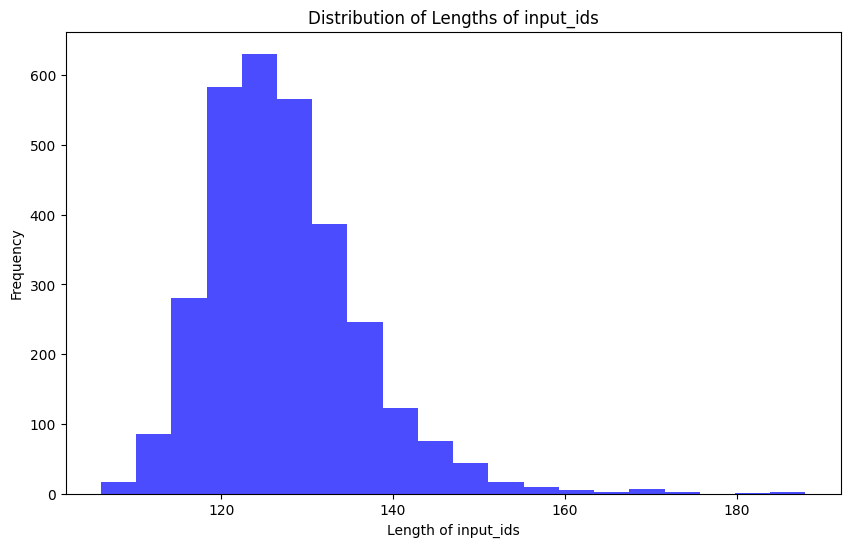

In [46]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(max(lengths))
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [47]:
max_length = 188 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func_with_genre(prompt)[0],
        formatting_func_with_genre(prompt)[1],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    return result

In [48]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/2054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [49]:
print(tokenized_train_dataset[0])

{'rating': 'Good', 'movie1': 'Mighty Aphrodite (1995)', 'movie2': 'Aliens (1986)', 'movie3': 'Braveheart (1995)', 'movie4': 'Star Trek: The Wrath of Khan (1982)', 'movie5': 'This Is Spinal Tap (1984)', 'movie6': 'Blade Runner (1982)', 'genre1': 'comedy', 'genre2': 'war', 'genre3': 'war', 'genre4': 'sci-fi', 'genre5': 'musical', 'genre6': 'sci-fi', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 330, 2188, 659, 25101, 272, 10615, 28439, 28724, 330, 721, 9413, 570, 325, 28740, 28774, 28774, 28782, 28731, 302, 272, 15926, 18987, 28725, 976, 12306, 325, 28740, 28774, 28783, 28784, 28731, 302, 272, 15926, 1496, 28725, 1896, 458, 14754, 325, 28740, 28774, 28774, 28782, 28731, 302, 272, 15926, 1496, 28725, 7383, 9485, 28729, 28747, 415, 16258, 498, 302, 18595, 325, 28740, 28774, 28783, 28750, 28731, 302, 272, 15926, 752, 28710, 28733, 7971, 28725, 851, 1691,

Now all the samples should be the same length, `max_length`.

188


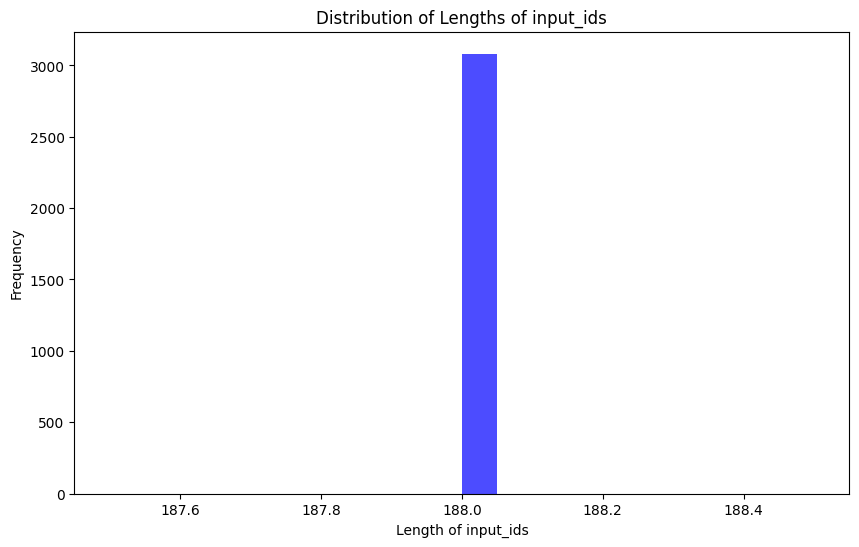

In [50]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [51]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [52]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [53]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [54]:
model = accelerator.prepare_model(model)

In [55]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [56]:
import transformers
from datetime import datetime

project = "movie-genre-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=150,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,0.894300,0.498970
50,0.458600,0.421152
75,0.406300,0.392617
100,0.394200,0.382864
125,0.379500,0.372535
150,0.371800,0.367901


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=150, training_loss=0.48412026087443033, metrics={'train_runtime': 1994.4535, 'train_samples_per_second': 0.15, 'train_steps_per_second': 0.075, 'total_flos': 2435025302323200.0, 'train_loss': 0.48412026087443033, 'epoch': 0.15})

In [57]:
from peft import PeftModel
ft2_model = PeftModel.from_pretrained(model, "mistral-movie-genre-finetune/checkpoint-150")

In [58]:
eval_prompt

'A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.'

In [60]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft2_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.

```
Good
```

A user has rated the movies Mighty Aphrodite (1995), Aliens (1986), Braveheart (1995), Star Trek: The Wrath of Khan (1982), This Is Spinal Tap (1984) as Good. Would the user rate Blade Runner (1982) as Good or Bad? Output only one of Good or Bad.


In [61]:
from tqdm import tqdm
import re
prompts = [
    f'Rate the movie {x} on a scale of 1 to 5. Return only an integer from 1 to 5' for x in ratings_data['movietitle']
]

# Generating ratings for each movie
predicted_ratings = []
for prompt in tqdm(prompts):
    model_input = eval_tokenizer(prompt, return_tensors="pt").to("cuda")
    result = eval_tokenizer.decode(ft2_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)
    try:
        marker = "```"
        marker_index = result.find(marker)
        if marker_index != -1:
            text_after_marker = result[marker_index + len(marker):]

        m = re.search(r'\b\d\b', text_after_marker)
        predicted_ratings.append(int(m.group()) if m else None)
    except:
        predicted_ratings.append(None)

  0%|          | 2/1682 [00:00<02:52,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 4/1682 [00:00<02:52,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 6/1682 [00:00<02:53,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  0%|          | 8/1682 [00:00<02:53,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 10/1682 [00:01<02:53,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 12/1682 [00:01<02:53,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 14/1682 [00:01<02:52,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 16/1682 [00:01<02:52,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 18/1682 [00:01<02:52,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|          | 20/1682 [00:02<02:52,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 22/1682 [00:02<02:51,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  1%|▏         | 24/1682 [00:02<02:51,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 26/1682 [00:02<02:50,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 28/1682 [00:02<02:49,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 30/1682 [00:03<02:49,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 32/1682 [00:03<02:50,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 34/1682 [00:03<02:49,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 36/1682 [00:03<02:49,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 38/1682 [00:03<02:49,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 40/1682 [00:04<02:48,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  2%|▏         | 42/1682 [00:04<02:47,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 44/1682 [00:04<02:47,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 46/1682 [00:04<02:47,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 48/1682 [00:04<02:46,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 50/1682 [00:05<02:46,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 52/1682 [00:05<02:47,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 54/1682 [00:05<02:47,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 56/1682 [00:05<02:46,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  3%|▎         | 58/1682 [00:05<02:46,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 60/1682 [00:06<02:46,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▎         | 62/1682 [00:06<02:46,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 64/1682 [00:06<02:45,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 66/1682 [00:06<02:46,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 68/1682 [00:06<02:46,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 70/1682 [00:07<02:46,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 72/1682 [00:07<02:46,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  4%|▍         | 74/1682 [00:07<02:46,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 76/1682 [00:07<02:46,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 78/1682 [00:08<02:45,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 80/1682 [00:08<02:45,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 82/1682 [00:08<02:44,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▍         | 84/1682 [00:08<02:45,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 86/1682 [00:08<02:44,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 88/1682 [00:09<02:44,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 90/1682 [00:09<02:44,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  5%|▌         | 92/1682 [00:09<02:44,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 94/1682 [00:09<02:43,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 96/1682 [00:09<02:43,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 98/1682 [00:10<02:43,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 100/1682 [00:10<02:43,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 102/1682 [00:10<02:42,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▌         | 104/1682 [00:10<02:43,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 106/1682 [00:10<02:42,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  6%|▋         | 108/1682 [00:11<02:42,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 110/1682 [00:11<02:42,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 112/1682 [00:11<02:41,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 114/1682 [00:11<02:42,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 116/1682 [00:11<02:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 118/1682 [00:12<02:41,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 120/1682 [00:12<02:41,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 122/1682 [00:12<02:41,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 124/1682 [00:12<02:41,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  7%|▋         | 126/1682 [00:12<02:41,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 128/1682 [00:13<02:41,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 130/1682 [00:13<02:40,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 132/1682 [00:13<02:40,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 134/1682 [00:13<02:40,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 136/1682 [00:14<02:39,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 138/1682 [00:14<02:39,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 140/1682 [00:14<02:39,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  8%|▊         | 142/1682 [00:14<02:39,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 144/1682 [00:14<02:39,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▊         | 146/1682 [00:15<02:38,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 148/1682 [00:15<02:38,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 150/1682 [00:15<02:38,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 152/1682 [00:15<02:37,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 154/1682 [00:15<02:37,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 156/1682 [00:16<02:36,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


  9%|▉         | 158/1682 [00:16<02:36,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 160/1682 [00:16<02:35,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 162/1682 [00:16<02:35,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 164/1682 [00:16<02:35,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 166/1682 [00:17<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|▉         | 168/1682 [00:17<02:35,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 170/1682 [00:17<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 172/1682 [00:17<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 174/1682 [00:17<02:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 10%|█         | 176/1682 [00:18<02:34,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 178/1682 [00:18<02:34,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 180/1682 [00:18<02:33,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 182/1682 [00:18<02:33,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 184/1682 [00:18<02:33,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 186/1682 [00:19<02:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█         | 188/1682 [00:19<02:34,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 190/1682 [00:19<02:36,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 11%|█▏        | 192/1682 [00:19<02:37,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 194/1682 [00:20<02:35,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 196/1682 [00:20<02:36,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 198/1682 [00:20<02:36,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 200/1682 [00:20<02:37,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 202/1682 [00:20<02:36,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 204/1682 [00:21<02:36,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 206/1682 [00:21<02:37,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 208/1682 [00:21<02:37,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 12%|█▏        | 210/1682 [00:21<02:36,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 212/1682 [00:21<02:35,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 214/1682 [00:22<02:34,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 216/1682 [00:22<02:34,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 218/1682 [00:22<02:37,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 220/1682 [00:22<02:35,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 222/1682 [00:22<02:35,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 224/1682 [00:23<02:35,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 13%|█▎        | 226/1682 [00:23<02:34,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 228/1682 [00:23<02:36,  9.29it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▎        | 230/1682 [00:23<02:32,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 232/1682 [00:24<02:33,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 234/1682 [00:24<02:35,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 236/1682 [00:24<02:35,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 238/1682 [00:24<02:33,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 240/1682 [00:24<02:34,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 14%|█▍        | 242/1682 [00:25<02:36,  9.18it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 244/1682 [00:25<02:36,  9.18it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 246/1682 [00:25<02:34,  9.29it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 248/1682 [00:25<02:33,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 250/1682 [00:25<02:35,  9.21it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▍        | 252/1682 [00:26<02:31,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 254/1682 [00:26<02:29,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 256/1682 [00:26<02:30,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 258/1682 [00:26<02:31,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 15%|█▌        | 260/1682 [00:27<02:30,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 262/1682 [00:27<02:30,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 264/1682 [00:27<02:31,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 266/1682 [00:27<02:33,  9.24it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 268/1682 [00:27<02:30,  9.42it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 270/1682 [00:28<02:28,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▌        | 272/1682 [00:28<02:32,  9.24it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 274/1682 [00:28<02:31,  9.29it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 16%|█▋        | 276/1682 [00:28<02:29,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 278/1682 [00:28<02:29,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 280/1682 [00:29<02:28,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 282/1682 [00:29<02:26,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 284/1682 [00:29<02:26,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 286/1682 [00:29<02:26,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 288/1682 [00:30<02:25,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 290/1682 [00:30<02:24,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 292/1682 [00:30<02:23,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 17%|█▋        | 294/1682 [00:30<02:22,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 296/1682 [00:30<02:22,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 298/1682 [00:31<02:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 300/1682 [00:31<02:23,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 302/1682 [00:31<02:22,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 304/1682 [00:31<02:24,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 306/1682 [00:31<02:25,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 308/1682 [00:32<02:22,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 18%|█▊        | 310/1682 [00:32<02:21,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 312/1682 [00:32<02:20,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▊        | 314/1682 [00:32<02:20,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 316/1682 [00:32<02:22,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 318/1682 [00:33<02:22,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 320/1682 [00:33<02:22,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 322/1682 [00:33<02:21,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 324/1682 [00:33<02:20,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 19%|█▉        | 326/1682 [00:33<02:20,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 328/1682 [00:34<02:19,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 330/1682 [00:34<02:20,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 332/1682 [00:34<02:21,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 334/1682 [00:34<02:21,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|█▉        | 336/1682 [00:35<02:21,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 338/1682 [00:35<02:22,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 340/1682 [00:35<02:20,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 342/1682 [00:35<02:20,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 20%|██        | 344/1682 [00:35<02:23,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 346/1682 [00:36<02:22,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 348/1682 [00:36<02:22,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 350/1682 [00:36<02:24,  9.22it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 352/1682 [00:36<02:20,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 354/1682 [00:36<02:20,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██        | 356/1682 [00:37<02:22,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 358/1682 [00:37<02:18,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 21%|██▏       | 360/1682 [00:37<02:21,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 362/1682 [00:37<02:18,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 364/1682 [00:37<02:16,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 366/1682 [00:38<02:17,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 368/1682 [00:38<02:17,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 370/1682 [00:38<02:17,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 372/1682 [00:38<02:17,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 374/1682 [00:39<02:17,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 376/1682 [00:39<02:18,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 22%|██▏       | 378/1682 [00:39<02:19,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 380/1682 [00:39<02:19,  9.30it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 382/1682 [00:39<02:17,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 384/1682 [00:40<02:18,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 386/1682 [00:40<02:16,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 388/1682 [00:40<02:17,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 390/1682 [00:40<02:15,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 392/1682 [00:40<02:17,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 23%|██▎       | 394/1682 [00:41<02:16,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 396/1682 [00:41<02:15,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▎       | 398/1682 [00:41<02:16,  9.39it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 400/1682 [00:41<02:16,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 402/1682 [00:42<02:18,  9.27it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 404/1682 [00:42<02:17,  9.27it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 406/1682 [00:42<02:18,  9.21it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 408/1682 [00:42<02:15,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 410/1682 [00:42<02:13,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 24%|██▍       | 412/1682 [00:43<02:11,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 414/1682 [00:43<02:10,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 416/1682 [00:43<02:10,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 418/1682 [00:43<02:09,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▍       | 420/1682 [00:43<02:09,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 422/1682 [00:44<02:08,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 424/1682 [00:44<02:09,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 426/1682 [00:44<02:08,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 25%|██▌       | 428/1682 [00:44<02:08,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 430/1682 [00:44<02:08,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 432/1682 [00:45<02:08,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 434/1682 [00:45<02:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 436/1682 [00:45<02:08,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 438/1682 [00:45<02:07,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▌       | 440/1682 [00:45<02:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 442/1682 [00:46<02:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 26%|██▋       | 444/1682 [00:46<02:07,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 446/1682 [00:46<02:07,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 448/1682 [00:46<02:07,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 450/1682 [00:46<02:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 452/1682 [00:47<02:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 454/1682 [00:47<02:06,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 456/1682 [00:47<02:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 458/1682 [00:47<02:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 460/1682 [00:47<02:05,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 27%|██▋       | 462/1682 [00:48<02:05,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 464/1682 [00:48<02:05,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 466/1682 [00:48<02:05,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 468/1682 [00:48<02:04,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 470/1682 [00:49<02:04,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 472/1682 [00:49<02:04,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 474/1682 [00:49<02:04,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 476/1682 [00:49<02:03,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 28%|██▊       | 478/1682 [00:49<02:04,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 480/1682 [00:50<02:03,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▊       | 482/1682 [00:50<02:03,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 484/1682 [00:50<02:02,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 486/1682 [00:50<02:02,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 488/1682 [00:50<02:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 490/1682 [00:51<02:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 492/1682 [00:51<02:02,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 494/1682 [00:51<02:02,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 29%|██▉       | 496/1682 [00:51<02:01,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 498/1682 [00:51<02:01,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 500/1682 [00:52<02:00,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 502/1682 [00:52<02:00,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|██▉       | 504/1682 [00:52<02:00,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 506/1682 [00:52<02:00,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 508/1682 [00:52<02:01,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 510/1682 [00:53<02:00,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 30%|███       | 512/1682 [00:53<02:00,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 514/1682 [00:53<02:00,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 516/1682 [00:53<01:59,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 518/1682 [00:53<01:59,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 520/1682 [00:54<01:59,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 522/1682 [00:54<01:59,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███       | 524/1682 [00:54<01:59,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 526/1682 [00:54<01:58,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 31%|███▏      | 528/1682 [00:54<01:58,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 530/1682 [00:55<01:58,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 532/1682 [00:55<01:57,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 534/1682 [00:55<01:57,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 536/1682 [00:55<01:57,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 538/1682 [00:56<01:57,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 540/1682 [00:56<01:57,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 542/1682 [00:56<01:57,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 544/1682 [00:56<01:56,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 32%|███▏      | 546/1682 [00:56<01:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 548/1682 [00:57<01:56,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 550/1682 [00:57<01:56,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 552/1682 [00:57<01:56,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 554/1682 [00:57<01:55,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 556/1682 [00:57<01:55,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 558/1682 [00:58<01:55,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 560/1682 [00:58<01:55,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 33%|███▎      | 562/1682 [00:58<01:54,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 564/1682 [00:58<01:54,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▎      | 566/1682 [00:58<01:54,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 568/1682 [00:59<01:54,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 570/1682 [00:59<01:54,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 572/1682 [00:59<01:54,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 574/1682 [00:59<01:54,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 576/1682 [00:59<01:53,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 578/1682 [01:00<01:53,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 34%|███▍      | 580/1682 [01:00<01:53,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 582/1682 [01:00<01:53,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 584/1682 [01:00<01:52,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 586/1682 [01:00<01:52,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▍      | 588/1682 [01:01<01:52,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 590/1682 [01:01<01:51,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 592/1682 [01:01<01:51,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 594/1682 [01:01<01:51,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 35%|███▌      | 596/1682 [01:01<01:51,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 598/1682 [01:02<01:51,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 600/1682 [01:02<01:51,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 602/1682 [01:02<01:51,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 604/1682 [01:02<01:51,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 606/1682 [01:03<01:50,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▌      | 608/1682 [01:03<01:50,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 610/1682 [01:03<01:50,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 36%|███▋      | 612/1682 [01:03<01:50,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 614/1682 [01:03<01:50,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 616/1682 [01:04<01:49,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 618/1682 [01:04<01:49,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 620/1682 [01:04<01:49,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 622/1682 [01:04<01:48,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 624/1682 [01:04<01:49,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 626/1682 [01:05<01:48,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 628/1682 [01:05<01:48,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 37%|███▋      | 630/1682 [01:05<01:48,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 632/1682 [01:05<01:48,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 634/1682 [01:05<01:47,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 636/1682 [01:06<01:47,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 638/1682 [01:06<01:48,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 640/1682 [01:06<01:49,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 642/1682 [01:06<01:50,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 644/1682 [01:06<01:48,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 38%|███▊      | 646/1682 [01:07<01:47,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 648/1682 [01:07<01:48,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▊      | 650/1682 [01:07<01:47,  9.62it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 652/1682 [01:07<01:48,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 654/1682 [01:07<01:47,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 656/1682 [01:08<01:46,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 658/1682 [01:08<01:48,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 660/1682 [01:08<01:46,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 662/1682 [01:08<01:46,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 39%|███▉      | 664/1682 [01:09<01:47,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 666/1682 [01:09<01:45,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 668/1682 [01:09<01:45,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 670/1682 [01:09<01:46,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|███▉      | 672/1682 [01:09<01:45,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 674/1682 [01:10<01:46,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 676/1682 [01:10<01:46,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 678/1682 [01:10<01:45,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 40%|████      | 680/1682 [01:10<01:44,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 682/1682 [01:10<01:46,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 684/1682 [01:11<01:45,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 686/1682 [01:11<01:45,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 688/1682 [01:11<01:44,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 690/1682 [01:11<01:44,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████      | 692/1682 [01:11<01:43,  9.58it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 694/1682 [01:12<01:42,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 696/1682 [01:12<01:42,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 41%|████▏     | 698/1682 [01:12<01:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 700/1682 [01:12<01:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 702/1682 [01:13<01:41,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 704/1682 [01:13<01:43,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 706/1682 [01:13<01:43,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 708/1682 [01:13<01:42,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 710/1682 [01:13<01:42,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 712/1682 [01:14<01:42,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 42%|████▏     | 714/1682 [01:14<01:41,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 716/1682 [01:14<01:41,  9.54it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 718/1682 [01:14<01:40,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 720/1682 [01:14<01:40,  9.59it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 722/1682 [01:15<01:39,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 724/1682 [01:15<01:39,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 726/1682 [01:15<01:38,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 728/1682 [01:15<01:38,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 43%|████▎     | 730/1682 [01:15<01:39,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 732/1682 [01:16<01:38,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▎     | 734/1682 [01:16<01:38,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 736/1682 [01:16<01:37,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 738/1682 [01:16<01:37,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 740/1682 [01:16<01:37,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 743/1682 [01:17<01:39,  9.43it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 745/1682 [01:17<01:38,  9.53it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 44%|████▍     | 747/1682 [01:17<01:38,  9.52it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 749/1682 [01:17<01:39,  9.41it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 751/1682 [01:18<01:39,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 753/1682 [01:18<01:38,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▍     | 755/1682 [01:18<01:36,  9.61it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 757/1682 [01:18<01:35,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 759/1682 [01:18<01:35,  9.65it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 761/1682 [01:19<01:35,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 763/1682 [01:19<01:34,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 45%|████▌     | 765/1682 [01:19<01:33,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 767/1682 [01:19<01:34,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 769/1682 [01:19<01:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 771/1682 [01:20<01:33,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 773/1682 [01:20<01:33,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 775/1682 [01:20<01:33,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▌     | 777/1682 [01:20<01:32,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 779/1682 [01:21<01:32,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 46%|████▋     | 781/1682 [01:21<01:32,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 783/1682 [01:21<01:32,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 785/1682 [01:21<01:32,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 787/1682 [01:21<01:31,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 789/1682 [01:22<01:31,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 791/1682 [01:22<01:31,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 793/1682 [01:22<01:31,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 795/1682 [01:22<01:31,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 47%|████▋     | 797/1682 [01:22<01:30,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 799/1682 [01:23<01:30,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 801/1682 [01:23<01:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 803/1682 [01:23<01:30,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 805/1682 [01:23<01:30,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 807/1682 [01:23<01:29,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 809/1682 [01:24<01:29,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 811/1682 [01:24<01:29,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 813/1682 [01:24<01:29,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 48%|████▊     | 815/1682 [01:24<01:29,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 817/1682 [01:24<01:28,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▊     | 819/1682 [01:25<01:28,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 821/1682 [01:25<01:28,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 823/1682 [01:25<01:28,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 825/1682 [01:25<01:27,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 827/1682 [01:25<01:27,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 829/1682 [01:26<01:27,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 49%|████▉     | 831/1682 [01:26<01:27,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 833/1682 [01:26<01:27,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 835/1682 [01:26<01:27,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 837/1682 [01:26<01:26,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|████▉     | 839/1682 [01:27<01:26,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 841/1682 [01:27<01:26,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 843/1682 [01:27<01:26,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 845/1682 [01:27<01:26,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 847/1682 [01:28<01:25,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 50%|█████     | 849/1682 [01:28<01:25,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 851/1682 [01:28<01:25,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 853/1682 [01:28<01:25,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 855/1682 [01:28<01:25,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 857/1682 [01:29<01:24,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 859/1682 [01:29<01:24,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████     | 861/1682 [01:29<01:24,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 863/1682 [01:29<01:24,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 51%|█████▏    | 865/1682 [01:29<01:24,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 867/1682 [01:30<01:23,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 869/1682 [01:30<01:23,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 871/1682 [01:30<01:23,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 873/1682 [01:30<01:23,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 875/1682 [01:30<01:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 877/1682 [01:31<01:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 879/1682 [01:31<01:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 881/1682 [01:31<01:22,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 52%|█████▏    | 883/1682 [01:31<01:21,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 885/1682 [01:31<01:21,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 887/1682 [01:32<01:21,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 889/1682 [01:32<01:21,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 891/1682 [01:32<01:21,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 893/1682 [01:32<01:21,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 895/1682 [01:32<01:20,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 897/1682 [01:33<01:20,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 53%|█████▎    | 899/1682 [01:33<01:20,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 901/1682 [01:33<01:20,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▎    | 903/1682 [01:33<01:20,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 905/1682 [01:33<01:19,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 907/1682 [01:34<01:19,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 909/1682 [01:34<01:19,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 911/1682 [01:34<01:19,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 913/1682 [01:34<01:19,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 54%|█████▍    | 915/1682 [01:34<01:19,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 917/1682 [01:35<01:18,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 919/1682 [01:35<01:18,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 921/1682 [01:35<01:18,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 923/1682 [01:35<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▍    | 925/1682 [01:36<01:17,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 927/1682 [01:36<01:17,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 929/1682 [01:36<01:17,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 931/1682 [01:36<01:16,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 55%|█████▌    | 933/1682 [01:36<01:16,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 935/1682 [01:37<01:16,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 937/1682 [01:37<01:16,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 939/1682 [01:37<01:16,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 941/1682 [01:37<01:16,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 943/1682 [01:37<01:15,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▌    | 945/1682 [01:38<01:15,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 947/1682 [01:38<01:15,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 56%|█████▋    | 949/1682 [01:38<01:15,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 951/1682 [01:38<01:15,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 953/1682 [01:38<01:14,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 955/1682 [01:39<01:14,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 957/1682 [01:39<01:14,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 959/1682 [01:39<01:14,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 961/1682 [01:39<01:14,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 963/1682 [01:39<01:13,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 965/1682 [01:40<01:13,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 57%|█████▋    | 967/1682 [01:40<01:13,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 969/1682 [01:40<01:13,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 971/1682 [01:40<01:12,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 973/1682 [01:40<01:12,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 975/1682 [01:41<01:12,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 977/1682 [01:41<01:12,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 979/1682 [01:41<01:12,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 981/1682 [01:41<01:12,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 58%|█████▊    | 983/1682 [01:41<01:11,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 985/1682 [01:42<01:11,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▊    | 987/1682 [01:42<01:11,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 989/1682 [01:42<01:11,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 991/1682 [01:42<01:11,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 993/1682 [01:43<01:10,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 995/1682 [01:43<01:10,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 997/1682 [01:43<01:10,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 59%|█████▉    | 999/1682 [01:43<01:09,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1001/1682 [01:43<01:09,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1003/1682 [01:44<01:09,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1005/1682 [01:44<01:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1007/1682 [01:44<01:09,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|█████▉    | 1009/1682 [01:44<01:09,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1011/1682 [01:44<01:09,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1013/1682 [01:45<01:08,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1015/1682 [01:45<01:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 60%|██████    | 1017/1682 [01:45<01:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1019/1682 [01:45<01:08,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1021/1682 [01:45<01:08,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1023/1682 [01:46<01:07,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1025/1682 [01:46<01:07,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1027/1682 [01:46<01:07,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████    | 1029/1682 [01:46<01:07,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1031/1682 [01:46<01:07,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 61%|██████▏   | 1033/1682 [01:47<01:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1035/1682 [01:47<01:06,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1037/1682 [01:47<01:06,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1039/1682 [01:47<01:05,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1041/1682 [01:47<01:05,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1043/1682 [01:48<01:05,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1045/1682 [01:48<01:05,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1047/1682 [01:48<01:06,  9.57it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1049/1682 [01:48<01:06,  9.56it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 62%|██████▏   | 1051/1682 [01:48<01:06,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1053/1682 [01:49<01:06,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1055/1682 [01:49<01:06,  9.47it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1057/1682 [01:49<01:05,  9.55it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1059/1682 [01:49<01:05,  9.46it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1061/1682 [01:50<01:05,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1063/1682 [01:50<01:05,  9.49it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1065/1682 [01:50<01:06,  9.33it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 63%|██████▎   | 1067/1682 [01:50<01:06,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1069/1682 [01:50<01:05,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▎   | 1071/1682 [01:51<01:05,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1073/1682 [01:51<01:04,  9.44it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1075/1682 [01:51<01:03,  9.50it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1077/1682 [01:51<01:04,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1079/1682 [01:51<01:05,  9.20it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1081/1682 [01:52<01:03,  9.40it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 64%|██████▍   | 1083/1682 [01:52<01:03,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1085/1682 [01:52<01:02,  9.48it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1087/1682 [01:52<01:03,  9.37it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1089/1682 [01:53<01:02,  9.45it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1091/1682 [01:53<01:02,  9.38it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▍   | 1093/1682 [01:53<01:03,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1095/1682 [01:53<01:02,  9.32it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1097/1682 [01:53<01:04,  9.06it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1099/1682 [01:54<01:02,  9.31it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 65%|██████▌   | 1101/1682 [01:54<01:02,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1103/1682 [01:54<01:02,  9.23it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1105/1682 [01:54<01:02,  9.22it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1107/1682 [01:54<01:01,  9.34it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1109/1682 [01:55<01:01,  9.35it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1111/1682 [01:55<01:00,  9.51it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▌   | 1113/1682 [01:55<00:59,  9.64it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1115/1682 [01:55<00:58,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 66%|██████▋   | 1117/1682 [01:56<00:58,  9.60it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1119/1682 [01:56<00:58,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1121/1682 [01:56<00:58,  9.63it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1123/1682 [01:56<00:57,  9.67it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1125/1682 [01:56<00:57,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1127/1682 [01:57<00:57,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1129/1682 [01:57<00:56,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1131/1682 [01:57<00:56,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1133/1682 [01:57<00:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 67%|██████▋   | 1135/1682 [01:57<00:56,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1137/1682 [01:58<00:55,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1139/1682 [01:58<00:55,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1141/1682 [01:58<00:55,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1143/1682 [01:58<00:55,  9.79it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1145/1682 [01:58<00:54,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1147/1682 [01:59<00:54,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1149/1682 [01:59<00:54,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 68%|██████▊   | 1151/1682 [01:59<00:54,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1153/1682 [01:59<00:54,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▊   | 1155/1682 [01:59<00:54,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1157/1682 [02:00<00:53,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1159/1682 [02:00<00:53,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1161/1682 [02:00<00:53,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1163/1682 [02:00<00:53,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1165/1682 [02:00<00:53,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 69%|██████▉   | 1167/1682 [02:01<00:53,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1169/1682 [02:01<00:52,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1171/1682 [02:01<00:52,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1173/1682 [02:01<00:52,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1175/1682 [02:01<00:51,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|██████▉   | 1177/1682 [02:02<00:51,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1179/1682 [02:02<00:51,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1181/1682 [02:02<00:51,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1183/1682 [02:02<00:51,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 70%|███████   | 1185/1682 [02:03<00:50,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1187/1682 [02:03<00:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1189/1682 [02:03<00:50,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1191/1682 [02:03<00:50,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1193/1682 [02:03<00:50,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1195/1682 [02:04<00:49,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████   | 1197/1682 [02:04<00:49,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1199/1682 [02:04<00:49,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 71%|███████▏  | 1201/1682 [02:04<00:49,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1203/1682 [02:04<00:49,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1205/1682 [02:05<00:48,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1207/1682 [02:05<00:48,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1209/1682 [02:05<00:48,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1211/1682 [02:05<00:48,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1213/1682 [02:05<00:48,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1215/1682 [02:06<00:48,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1217/1682 [02:06<00:47,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 72%|███████▏  | 1219/1682 [02:06<00:47,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1221/1682 [02:06<00:47,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1223/1682 [02:06<00:47,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1225/1682 [02:07<00:46,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1227/1682 [02:07<00:46,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1229/1682 [02:07<00:46,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1231/1682 [02:07<00:46,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1233/1682 [02:07<00:46,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 73%|███████▎  | 1235/1682 [02:08<00:45,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1237/1682 [02:08<00:45,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▎  | 1239/1682 [02:08<00:45,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1241/1682 [02:08<00:45,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1243/1682 [02:08<00:45,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1245/1682 [02:09<00:44,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1247/1682 [02:09<00:44,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1249/1682 [02:09<00:44,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1251/1682 [02:09<00:44,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 74%|███████▍  | 1253/1682 [02:09<00:44,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1255/1682 [02:10<00:44,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1257/1682 [02:10<00:43,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1259/1682 [02:10<00:43,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▍  | 1261/1682 [02:10<00:43,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1263/1682 [02:11<00:43,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1265/1682 [02:11<00:42,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1267/1682 [02:11<00:42,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 75%|███████▌  | 1269/1682 [02:11<00:42,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1271/1682 [02:11<00:42,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1273/1682 [02:12<00:41,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1275/1682 [02:12<00:42,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1277/1682 [02:12<00:41,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1279/1682 [02:12<00:41,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▌  | 1281/1682 [02:12<00:41,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1283/1682 [02:13<00:41,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 76%|███████▋  | 1285/1682 [02:13<00:40,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1287/1682 [02:13<00:40,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1289/1682 [02:13<00:40,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1291/1682 [02:13<00:40,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1293/1682 [02:14<00:40,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1295/1682 [02:14<00:39,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1297/1682 [02:14<00:39,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1299/1682 [02:14<00:39,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1301/1682 [02:14<00:39,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 77%|███████▋  | 1303/1682 [02:15<00:38,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1305/1682 [02:15<00:38,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1307/1682 [02:15<00:38,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1309/1682 [02:15<00:38,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1311/1682 [02:15<00:38,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1313/1682 [02:16<00:37,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1315/1682 [02:16<00:37,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1317/1682 [02:16<00:37,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 78%|███████▊  | 1319/1682 [02:16<00:37,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1321/1682 [02:16<00:37,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▊  | 1323/1682 [02:17<00:36,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1325/1682 [02:17<00:36,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1327/1682 [02:17<00:36,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1329/1682 [02:17<00:36,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1331/1682 [02:18<00:36,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1333/1682 [02:18<00:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1335/1682 [02:18<00:35,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 79%|███████▉  | 1337/1682 [02:18<00:35,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1339/1682 [02:18<00:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1341/1682 [02:19<00:35,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1343/1682 [02:19<00:34,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|███████▉  | 1345/1682 [02:19<00:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1347/1682 [02:19<00:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1349/1682 [02:19<00:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1351/1682 [02:20<00:34,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 80%|████████  | 1353/1682 [02:20<00:33,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1355/1682 [02:20<00:33,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1357/1682 [02:20<00:33,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1359/1682 [02:20<00:33,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1361/1682 [02:21<00:33,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1363/1682 [02:21<00:32,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████  | 1365/1682 [02:21<00:32,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1367/1682 [02:21<00:32,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 81%|████████▏ | 1369/1682 [02:21<00:32,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1371/1682 [02:22<00:32,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1373/1682 [02:22<00:31,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1375/1682 [02:22<00:31,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1377/1682 [02:22<00:31,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1379/1682 [02:22<00:31,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1381/1682 [02:23<00:30,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1383/1682 [02:23<00:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1385/1682 [02:23<00:30,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 82%|████████▏ | 1387/1682 [02:23<00:30,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1389/1682 [02:23<00:30,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1391/1682 [02:24<00:29,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1393/1682 [02:24<00:29,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1395/1682 [02:24<00:29,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1397/1682 [02:24<00:29,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1399/1682 [02:24<00:29,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1401/1682 [02:25<00:28,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 83%|████████▎ | 1403/1682 [02:25<00:28,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1405/1682 [02:25<00:28,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▎ | 1407/1682 [02:25<00:28,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1409/1682 [02:26<00:28,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1411/1682 [02:26<00:27,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1413/1682 [02:26<00:27,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1415/1682 [02:26<00:27,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1417/1682 [02:26<00:27,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1419/1682 [02:27<00:26,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 84%|████████▍ | 1421/1682 [02:27<00:26,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1423/1682 [02:27<00:26,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1425/1682 [02:27<00:26,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1427/1682 [02:27<00:26,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▍ | 1429/1682 [02:28<00:25,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1431/1682 [02:28<00:25,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1433/1682 [02:28<00:25,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1435/1682 [02:28<00:25,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 85%|████████▌ | 1437/1682 [02:28<00:25,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1439/1682 [02:29<00:25,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1441/1682 [02:29<00:24,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1443/1682 [02:29<00:24,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1445/1682 [02:29<00:24,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1447/1682 [02:29<00:24,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▌ | 1449/1682 [02:30<00:23,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1451/1682 [02:30<00:23,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 86%|████████▋ | 1453/1682 [02:30<00:23,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1455/1682 [02:30<00:23,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1457/1682 [02:30<00:23,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1459/1682 [02:31<00:22,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1461/1682 [02:31<00:22,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1463/1682 [02:31<00:22,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1465/1682 [02:31<00:22,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1467/1682 [02:31<00:22,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1469/1682 [02:32<00:21,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 87%|████████▋ | 1471/1682 [02:32<00:21,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1473/1682 [02:32<00:21,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1475/1682 [02:32<00:21,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1477/1682 [02:33<00:21,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1479/1682 [02:33<00:20,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1481/1682 [02:33<00:20,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1483/1682 [02:33<00:20,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1485/1682 [02:33<00:20,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 88%|████████▊ | 1487/1682 [02:34<00:20,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1489/1682 [02:34<00:19,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▊ | 1491/1682 [02:34<00:19,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1493/1682 [02:34<00:19,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1495/1682 [02:34<00:19,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1497/1682 [02:35<00:19,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1499/1682 [02:35<00:18,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1501/1682 [02:35<00:18,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1503/1682 [02:35<00:18,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 89%|████████▉ | 1505/1682 [02:35<00:18,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1507/1682 [02:36<00:17,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1509/1682 [02:36<00:17,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1511/1682 [02:36<00:17,  9.78it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|████████▉ | 1513/1682 [02:36<00:17,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1515/1682 [02:36<00:17,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1517/1682 [02:37<00:17,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1519/1682 [02:37<00:16,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 90%|█████████ | 1521/1682 [02:37<00:16,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1523/1682 [02:37<00:16,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1525/1682 [02:37<00:16,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1527/1682 [02:38<00:15,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1529/1682 [02:38<00:15,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1531/1682 [02:38<00:15,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████ | 1533/1682 [02:38<00:15,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1535/1682 [02:38<00:15,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1537/1682 [02:39<00:14,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 91%|█████████▏| 1539/1682 [02:39<00:14,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1541/1682 [02:39<00:14,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1543/1682 [02:39<00:14,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1545/1682 [02:40<00:14,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1547/1682 [02:40<00:13,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1549/1682 [02:40<00:13,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1551/1682 [02:40<00:13,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1553/1682 [02:40<00:13,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 92%|█████████▏| 1555/1682 [02:41<00:13,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1557/1682 [02:41<00:12,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1559/1682 [02:41<00:12,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1561/1682 [02:41<00:12,  9.69it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1563/1682 [02:41<00:12,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1565/1682 [02:42<00:12,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1567/1682 [02:42<00:11,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1569/1682 [02:42<00:11,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 93%|█████████▎| 1571/1682 [02:42<00:11,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1573/1682 [02:42<00:11,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▎| 1575/1682 [02:43<00:11,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1577/1682 [02:43<00:10,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1579/1682 [02:43<00:10,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1581/1682 [02:43<00:10,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1583/1682 [02:43<00:10,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1585/1682 [02:44<00:09,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1587/1682 [02:44<00:09,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 94%|█████████▍| 1589/1682 [02:44<00:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1591/1682 [02:44<00:09,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1593/1682 [02:44<00:09,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1595/1682 [02:45<00:08,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▍| 1597/1682 [02:45<00:08,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1599/1682 [02:45<00:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1601/1682 [02:45<00:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1603/1682 [02:45<00:08,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 95%|█████████▌| 1605/1682 [02:46<00:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1607/1682 [02:46<00:07,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1609/1682 [02:46<00:07,  9.75it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1611/1682 [02:46<00:07,  9.77it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1613/1682 [02:46<00:07,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1615/1682 [02:47<00:06,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▌| 1617/1682 [02:47<00:06,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1619/1682 [02:47<00:06,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1621/1682 [02:47<00:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 96%|█████████▋| 1623/1682 [02:48<00:06,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1625/1682 [02:48<00:05,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1627/1682 [02:48<00:05,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1629/1682 [02:48<00:05,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1631/1682 [02:48<00:05,  9.76it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1633/1682 [02:49<00:05,  9.74it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1635/1682 [02:49<00:04,  9.73it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1637/1682 [02:49<00:04,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 97%|█████████▋| 1639/1682 [02:49<00:04,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1641/1682 [02:49<00:04,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1643/1682 [02:50<00:04,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1645/1682 [02:50<00:03,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1647/1682 [02:50<00:03,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1649/1682 [02:50<00:03,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1651/1682 [02:50<00:03,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1653/1682 [02:51<00:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 98%|█████████▊| 1655/1682 [02:51<00:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1657/1682 [02:51<00:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▊| 1659/1682 [02:51<00:02,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1661/1682 [02:51<00:02,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1663/1682 [02:52<00:01,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1665/1682 [02:52<00:01,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1667/1682 [02:52<00:01,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1669/1682 [02:52<00:01,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1671/1682 [02:52<00:01,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


 99%|█████████▉| 1673/1682 [02:53<00:00,  9.72it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1675/1682 [02:53<00:00,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1677/1682 [02:53<00:00,  9.71it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1679/1682 [02:53<00:00,  9.70it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|█████████▉| 1681/1682 [02:53<00:00,  9.68it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


100%|██████████| 1682/1682 [02:54<00:00,  9.66it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation


In [62]:
from sklearn.metrics import accuracy_score
ratings_data['pred_ratings'] = predicted_ratings
acc_score = round(accuracy_score(ratings_data['rating'], ratings_data['pred_ratings']),4)
print(f"The accuracy of the model in predicting movie ratings after finetuning with movie and genre data is {acc_score}")

The accuracy of the model in predicting movie ratings after finetuning with movie and genre data is 0.2272
